In [0]:
from google.colab import drive
drive.mount('/content/drive')




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from matplotlib import pyplot as plt

import copy

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


In [0]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False)


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

foreground_classes = {'horse','ship', 'truck'}

background_classes = {'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog'}

# print(type(foreground_classes))

In [0]:
dataiter = iter(trainloader)
background_data=[]
background_label=[]
foreground_data=[]
foreground_label=[]
batch_size=10

for i in range(5000):
  images, labels = dataiter.next()
  for j in range(batch_size):
    if(classes[labels[j]] in background_classes):
      img = images[j].tolist()
      background_data.append(img)
      background_label.append(labels[j])
    else:
      img = images[j].tolist()
      foreground_data.append(img)
      foreground_label.append(labels[j])
            
foreground_data = torch.tensor(foreground_data)
foreground_label = torch.tensor(foreground_label)
background_data = torch.tensor(background_data)
background_label = torch.tensor(background_label)
    

In [0]:
def imshow(img):
  img = img / 2 + 0.5     # unnormalize
  npimg = img#.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

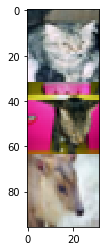

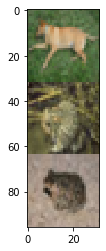

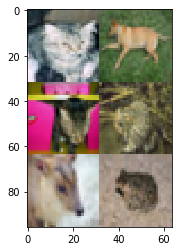

torch.Size([3, 96, 32])


In [0]:
img1 = torch.cat((background_data[0],background_data[1],background_data[2]),1)
imshow(img1)
img2 = torch.cat((background_data[27],background_data[3],background_data[43]),1)
imshow(img2)
img3 = torch.cat((img1,img2),2)
imshow(img3)
print(img2.size())


In [0]:
def create_mosaic_img(bg_idx,fg_idx,fg): 
  """
  bg_idx : list of indexes of background_data[] to be used as background images in mosaic
  fg_idx : index of image to be used as foreground image from foreground data
  fg : at what position/index foreground image has to be stored out of 0-8
  """
  image_list=[]
  j=0
  for i in range(9):
    if i != fg:
      image_list.append(background_data[bg_idx[j]].type("torch.DoubleTensor"))
      j+=1
    else: 
      image_list.append(foreground_data[fg_idx].type("torch.DoubleTensor"))
      label = foreground_label[fg_idx]-7  # minus 7 because our fore ground classes are 7,8,9 but we have to store it as 0,1,2
  #image_list = np.concatenate(image_list ,axis=0)
  image_list = torch.stack(image_list) 
  return image_list,label

In [0]:
desired_num = 30000
mosaic_list_of_images =[]      # list of mosaic images, each mosaic image is saved as list of 9 images
fore_idx =[]                   # list of indexes at which foreground image is present in a mosaic image i.e from 0 to 9               
mosaic_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(desired_num):
  bg_idx = np.random.randint(0,35000,8)
  fg_idx = np.random.randint(0,15000)
  fg = np.random.randint(0,9)
  fore_idx.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  mosaic_list_of_images.append(image_list)
  mosaic_label.append(label)



2


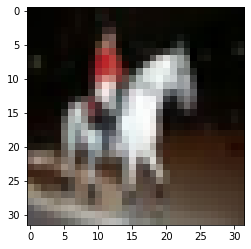

horse


In [0]:
qw=45

print(fore_idx[qw])
imshow(mosaic_list_of_images[qw][fore_idx[qw]])
# print(mosaic_list_of_images[0])
print(classes[mosaic_label[qw]+7]) # add 7 as we had subtracted 7 while saving

# imshow(mosaic_list_of_images[13][2])
# print(type(mosaic_list_of_images[1][0]))
# print(mosaic_label)

In [0]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label, fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    self.fore_idx = fore_idx

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]

batch = 250
msd = MosaicDataset(mosaic_list_of_images, mosaic_label , fore_idx)
train_loader = DataLoader( msd,batch_size= batch ,shuffle=True)

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Module1(nn.Module):
  def __init__(self):
    super(Module1, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    self.fc4 = nn.Linear(10,1)

  def forward(self, z):
    x = torch.zeros([batch,9],dtype=torch.float64)
    y = torch.zeros([batch,3, 32,32], dtype=torch.float64)
    x,y = x.to("cuda"),y.to("cuda")
    for i in range(9):
      x[:,i] = self.helper(z[:,i])[:,0]
    x = F.softmax(x,dim=1)   # alphas
    
    x1 = x[:,0]
    torch.mul(x1[:,None,None,None],z[:,0])

    for i in range(9):            
      x1 = x[:,i]          
      y = y + torch.mul(x1[:,None,None,None],z[:,i])
    return y , x 
  
  def helper(self,x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return x
      


In [0]:
 class Module2(nn.Module):
  def __init__(self):
    super(Module2, self).__init__()
    
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    self.fc4 = nn.Linear(10,3)

  def forward(self,y):  #z batch of list of 9 images
    y1 = self.pool(F.relu(self.conv1(y)))
    y1 = self.pool(F.relu(self.conv2(y1)))
    y1 = y1.view(-1, 16 * 5 * 5)

    y1 = F.relu(self.fc1(y1))
    y1 = F.relu(self.fc2(y1))
    y1 = F.relu(self.fc3(y1))
    y1 = self.fc4(y1)
    return y1 


In [0]:
where_net = Module1().double()
where_net = where_net.to("cuda")
# print(net.parameters)

In [0]:
# idx = np.random.randint(0,250,10)
# train_iter = iter(train_loader)
# images,labels,_=train_iter.next()

# for i in idx:
#   imshow(where_net1(images)[i].detach().numpy())

In [0]:
what_net = Module2().double()
what_net = what_net.to("cuda")

In [0]:
# where_net.load_state_dict(torch.load("model_epoch90.pt"))
# what_net.load_state_dict(torch.load("model_epoch90.pt"))
# print(fore_net.parameters)

In [0]:
test_images =[]        #list of mosaic images, each mosaic image is saved as laist of 9 images
fore_idx_test =[]                   #list of indexes at which foreground image is present in a mosaic image                
test_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(10000):
  bg_idx = np.random.randint(0,35000,8)
  fg_idx = np.random.randint(0,15000)
  fg = np.random.randint(0,9)
  fore_idx_test.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  test_images.append(image_list)
  test_label.append(label)

In [0]:
test_data = MosaicDataset(test_images,test_label,fore_idx_test)
test_loader = DataLoader( test_data,batch_size= batch ,shuffle=False)

In [144]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer_where = optim.SGD(where_net.parameters(), lr=0.01, momentum=0.9)
optimizer_what = optim.SGD(what_net.parameters(), lr=0.001, momentum=0.9)

nos_epochs = 600
every_what_epoch = 50
path = "/content/drive/My Drive/Research/stage_wise_training/where_what/alternate_training_600epochs_every50epoch_what_lr_001_where_lr_01_focus_vs_pred"
#---------------------------------------------
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0
argmax_more_than_half = 0
argmax_less_than_half =0
col1=[]
col2=[]
col3=[]
col4=[]
col5=[]
col6=[]
col7=[]
col8=[]
col9=[]
col10=[]
col11=[]
col12=[]
col13=[]
#-----------------------------------------------
train_loss=[]
test_loss =[]
train_acc = []
test_acc = []
for epoch in range(nos_epochs):  # loop over the dataset multiple times
    
  focus_true_pred_true =0
  focus_false_pred_true =0
  focus_true_pred_false =0
  focus_false_pred_false =0
  argmax_more_than_half = 0
  argmax_less_than_half =0
  
  running_loss = 0.0
  batch_correct = 0.0
  cnt=0
  total=0
  iteration = desired_num // batch



  #training data set

  if (epoch % (every_what_epoch*2) ) < every_what_epoch :
    print(epoch,"updating where_net, what_net is freezed") 
  elif (epoch % (every_what_epoch*2)) > every_what_epoch :
    print(epoch,"updating what_net, where_net is freezed")
      
    
  for i, data in  enumerate(train_loader):
      inputs , labels , fore_idx = data
      inputs,labels = inputs.to("cuda"),labels.to("cuda") 
      # zero the parameter gradients
      
      optimizer_what.zero_grad()
      optimizer_where.zero_grad()
      
      avg_images , alphas = where_net(inputs)
      outputs = what_net(avg_images)
      
      _, predicted = torch.max(outputs.data, 1)
      

      loss = criterion(outputs, labels) 
      loss.backward() 
  
      if (epoch % (every_what_epoch*2) ) < every_what_epoch :
        optimizer_where.step()
          
      elif (epoch % (every_what_epoch*2)) > every_what_epoch :
        optimizer_what.step()
          
      batch_correct += sum(predicted == labels)
      total += len(predicted)
      running_loss += loss.item()
      if cnt % 120 == 119:    # print every 40 mini-batches
          print("--"*40)
          print("Epoch: ",epoch)
#             print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt + 1, running_loss / 120))
          train_loss.append(running_loss/120)
          train_acc.append(batch_correct.item()/desired_num)
          print("total_Correct:",batch_correct.item(),"Total:",total,"train_loss",running_loss/120,"train_acc: ", batch_correct.item()/total)
          #running_loss = 0.0
      cnt=cnt+1

      if epoch % 5 == 0:
        for j in range (batch):
          focus = torch.argmax(alphas[j])

          if(alphas[j][focus] >= 0.5):
            argmax_more_than_half +=1
          else:
            argmax_less_than_half +=1

          if(focus == fore_idx[j] and predicted[j] == labels[j]):
            focus_true_pred_true += 1

          elif(focus != fore_idx[j] and predicted[j] == labels[j]):
            focus_false_pred_true +=1

          elif(focus == fore_idx[j] and predicted[j] != labels[j]):
            focus_true_pred_false +=1

          elif(focus != fore_idx[j] and predicted[j] != labels[j]):
            focus_false_pred_false +=1

  if epoch % 5 == 0:
    col1.append(epoch)
    col2.append(argmax_more_than_half)
    col3.append(argmax_less_than_half)
    col4.append(focus_true_pred_true)
    col5.append(focus_false_pred_true)
    col6.append(focus_true_pred_false)
    col7.append(focus_false_pred_false)
  
    with torch.no_grad():
      loss = 0.0
      correct = 0.0
      tot =0
      focus_true_pred_true =0
      focus_false_pred_true =0
      focus_true_pred_false =0
      focus_false_pred_false =0
      argmax_more_than_half = 0
      argmax_less_than_half =0

      for data in test_loader:
        inputs, labels , fore_idx = data
        inputs,labels = inputs.to("cuda"),labels.to("cuda") 
        avg_images , alphas = where_net(inputs)
        outputs = what_net(avg_images)
        _, predicted = torch.max(outputs.data, 1)
        loss += criterion(outputs, labels).item() 
        correct += sum(predicted == labels)
        tot += len(predicted)

        for j in range (batch):
          focus = torch.argmax(alphas[j])

          if(alphas[j][focus] >= 0.5):
            argmax_more_than_half +=1
          else:
            argmax_less_than_half +=1

          if(focus == fore_idx[j] and predicted[j] == labels[j]):
            focus_true_pred_true += 1

          elif(focus != fore_idx[j] and predicted[j] == labels[j]):
            focus_false_pred_true +=1

          elif(focus == fore_idx[j] and predicted[j] != labels[j]):
            focus_true_pred_false +=1

          elif(focus != fore_idx[j] and predicted[j] != labels[j]):
            focus_false_pred_false +=1
          
      test_loss.append(loss/40) # 10000/250 = 40
      test_acc.append(correct.item()/tot)
      print("total_Correct:",correct.item(),"Total:",tot,"test loss: ", loss/40, "test accuracy", correct.item()/tot)

    col8.append(argmax_more_than_half)
    col9.append(argmax_less_than_half)
    col10.append(focus_true_pred_true)
    col11.append(focus_false_pred_true)
    col12.append(focus_true_pred_false)
    col13.append(focus_false_pred_false)

  elif epoch % 5 != 0  :
    with torch.no_grad():
      loss = 0.0
      correct = 0.0
      tot =0
      for data in test_loader:
        inputs, labels , fore_idx = data
        inputs,labels = inputs.to("cuda"),labels.to("cuda") 
        avg_images , alphas = where_net(inputs)
        outputs = what_net(avg_images)
        _, predicted = torch.max(outputs.data, 1)
        loss += criterion(outputs, labels).item() 
        correct += sum(predicted == labels)
        tot += len(predicted)

      test_loss.append(loss/40) # 10000/250 = 40
      test_acc.append(correct.item()/tot)
      print("total_Correct:",correct.item(),"Total:",tot,"test loss: ", loss/40, "test accuracy", correct.item()/tot)
 
    
  if (epoch % (every_what_epoch*2) == every_what_epoch*2 - 1):
      torch.save(where_net.state_dict(),path + "/where_model_at_epoch"+str(epoch)+".pt")
      torch.save(what_net.state_dict(),path + "/what_model_at_epoch"+str(epoch)+".pt")
    
print('Finished Training')

torch.save(where_net.state_dict(),path + "/full_where_model_epoch"+str(nos_epochs)+".pt")
torch.save(what_net.state_dict(),path + "/full_what_model_epoch"+str(nos_epochs)+".pt")

0 updating where_net, what_net is freezed
--------------------------------------------------------------------------------
Epoch:  0
total_Correct: 9869.0 Total: 30000 train_loss 1.120412472575653 train_acc:  0.3289666666666667
total_Correct: 3315.0 Total: 10000 test loss:  1.1194680518394733 test accuracy 0.3315
1 updating where_net, what_net is freezed
--------------------------------------------------------------------------------
Epoch:  1
total_Correct: 9869.0 Total: 30000 train_loss 1.1204124725046742 train_acc:  0.3289666666666667
total_Correct: 3315.0 Total: 10000 test loss:  1.1194680517805662 test accuracy 0.3315
2 updating where_net, what_net is freezed
--------------------------------------------------------------------------------
Epoch:  2
total_Correct: 9869.0 Total: 30000 train_loss 1.1204124724333835 train_acc:  0.3289666666666667
total_Correct: 3315.0 Total: 10000 test loss:  1.1194680517215123 test accuracy 0.3315
3 updating where_net, what_net is freezed
-----------

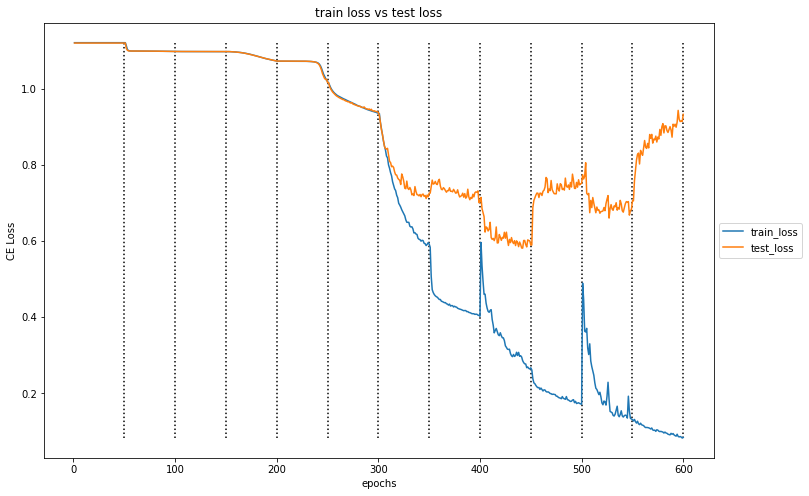

In [145]:
fig = plt.figure(figsize = (12,8) )
vline_list = np.arange(every_what_epoch, nos_epochs + every_what_epoch, every_what_epoch )
# train_loss = np.random.randn(340)
# test_loss = np.random.randn(340)
epoch_list = np.arange(1, nos_epochs+1)
plt.plot(epoch_list,train_loss, label='train_loss')
plt.plot(epoch_list,test_loss, label='test_loss')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("CE Loss")
plt.vlines(vline_list,min(min(train_loss),min(test_loss)), max(max(test_loss),max(train_loss)),linestyles='dotted')
plt.title("train loss vs test loss")
plt.show()
fig.savefig("train_test_loss_plot.pdf")


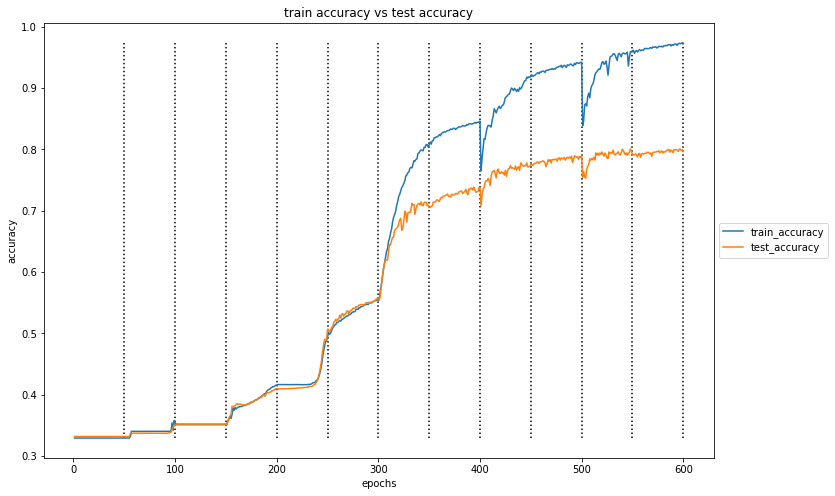

In [146]:
fig = plt.figure(figsize = (12,8) )
vline_list = np.arange(every_what_epoch, nos_epochs + every_what_epoch, every_what_epoch )
# train_acc = np.random.randn(340)
# test_acc = np.random.randn(340)
epoch_list = np.arange(1, nos_epochs+1)
plt.plot(epoch_list,train_acc, label='train_accuracy')
plt.plot(epoch_list,test_acc, label='test_accuracy')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.vlines(vline_list,min(min(train_acc),min(test_acc)), max(max(test_acc),max(train_acc)),linestyles='dotted')
plt.title("train accuracy vs test accuracy")
plt.show()
fig.savefig("train_test_acc_plot.pdf")

In [0]:
columns = ["epochs", "argmax > 0.5" ,"argmax < 0.5", "focus_true_pred_true", "focus_false_pred_true", "focus_true_pred_false", "focus_false_pred_false" ]
df_train = pd.DataFrame()
df_test = pd.DataFrame()
df_train[columns[0]] = col1
df_train[columns[1]] = col2
df_train[columns[2]] = col3
df_train[columns[3]] = col4
df_train[columns[4]] = col5
df_train[columns[5]] = col6
df_train[columns[6]] = col7

df_test[columns[0]] = col1
df_test[columns[1]] = col8
df_test[columns[2]] = col9
df_test[columns[3]] = col10
df_test[columns[4]] = col11
df_test[columns[5]] = col12
df_test[columns[6]] = col13

In [148]:
df_train

epochs  argmax > 0.5  ...  focus_true_pred_false  focus_false_pred_false
0         0             0  ...                   1667                   18464
1         5             0  ...                   1666                   18465
2        10             0  ...                   1661                   18470
3        15             0  ...                   1659                   18472
4        20             0  ...                   1660                   18471
..      ...           ...  ...                    ...                     ...
115     575         27868  ...                    198                     756
116     580         27868  ...                    178                     743
117     585         27868  ...                    163                     715
118     590         27868  ...                    142                     712
119     595         27868  ...                    124                     679

[120 rows x 7 columns]

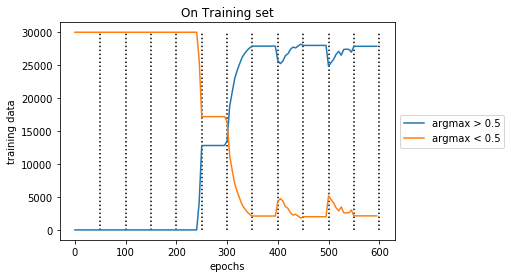

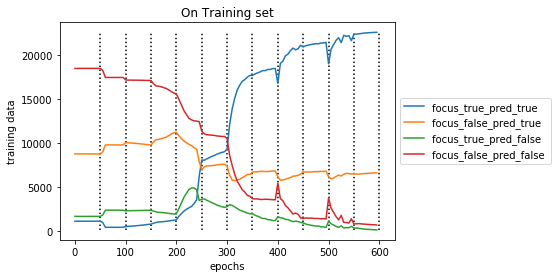

In [149]:
# plt.figure(12,12)
plt.plot(col1,col2, label='argmax > 0.5')
plt.plot(col1,col3, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("training data")
plt.title("On Training set")
plt.vlines(vline_list,min(min(col2),min(col3)), max(max(col2),max(col3)),linestyles='dotted')
plt.show()

plt.plot(col1,col4, label ="focus_true_pred_true ")
plt.plot(col1,col5, label ="focus_false_pred_true ")
plt.plot(col1,col6, label ="focus_true_pred_false ")
plt.plot(col1,col7, label ="focus_false_pred_false ")
plt.title("On Training set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("training data")
plt.vlines(vline_list,min(min(col4),min(col5),min(col6),min(col7)), max(max(col4),max(col5),max(col6),max(col7)),linestyles='dotted')
plt.show()

In [150]:
df_test

epochs  argmax > 0.5  ...  focus_true_pred_false  focus_false_pred_false
0         0             0  ...                    489                    6196
1         5             0  ...                    489                    6196
2        10             0  ...                    492                    6193
3        15             0  ...                    492                    6193
4        20             0  ...                    490                    6195
..      ...           ...  ...                    ...                     ...
115     575          8966  ...                    339                    1683
116     580          8966  ...                    351                    1683
117     585          8966  ...                    336                    1664
118     590          8966  ...                    338                    1666
119     595          8966  ...                    329                    1670

[120 rows x 7 columns]

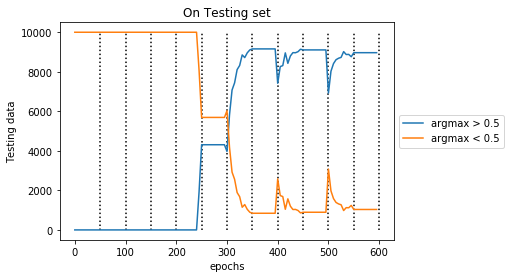

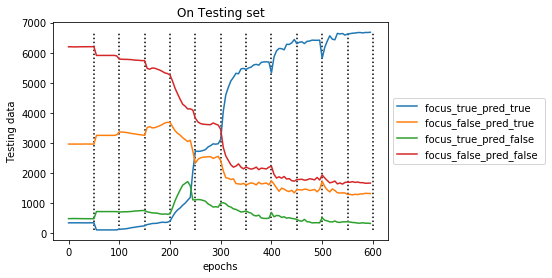

In [151]:
# plt.figure(12,12)
plt.plot(col1,col8, label='argmax > 0.5')
plt.plot(col1,col9, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("Testing data")
plt.title("On Testing set")
plt.vlines(vline_list,min(min(col8),min(col9)), max(max(col8),max(col9)),linestyles='dotted')
plt.show()

plt.plot(col1,col10, label ="focus_true_pred_true ")
plt.plot(col1,col11, label ="focus_false_pred_true ")
plt.plot(col1,col12, label ="focus_true_pred_false ")
plt.plot(col1,col13, label ="focus_false_pred_false ")
plt.title("On Testing set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("Testing data")
plt.vlines(vline_list,min(min(col10),min(col11),min(col12),min(col13)), max(max(col10),max(col11),max(col12),max(col13)),linestyles='dotted')
plt.show()

In [152]:
print("-"*20,"Training Dataset","-"*20)
print("epochs", col1) 
print("argmax > 0.5 ", col2) 
print("argmax < 0.5 ", col3) 
print("focus_true_pred_true", col4) 
print("focus_false_pred_true", col5)
print("focus_true_pred_false", col6) 
print("focus_false_pred_false", col7) 
print("-"*20,"Testing Dataset","-"*20)
print("argmax > 0.5 ", col8)
print("argmax < 0.5", col9) 
print("focus_true_pred_true", col10) 
print("focus_false_pred_true", col11)
print("focus_true_pred_false", col12) 
print("focus_false_pred_false", col13) 

-------------------- Training Dataset --------------------
epochs [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595]
argmax > 0.5  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4258, 12810, 12810, 12810, 12810, 12810, 12810, 12810, 12810, 12810, 12810, 13525, 18733, 20893, 22977, 24226, 25271, 26256, 26816, 27311, 27656, 27894, 27894, 27894, 27894, 27894, 27894, 27894

In [0]:
df_train.to_csv(path + "/focus_vs_predicted_train.csv")
df_test.to_csv(path + "/focus_vs_predicted_test.csv")

In [0]:
def display(img):
  img = img / 2 + 0.5     # unnormalize
  npimg = img
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

****************************************************************************************************


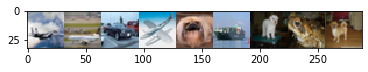

tensor([1.4729e-12, 9.4948e-13, 5.4524e-15, 2.1848e-14, 4.5462e-11, 1.0000e+00,
        8.2384e-12, 1.4433e-14, 6.8366e-12], device='cuda:0',
       dtype=torch.float64)


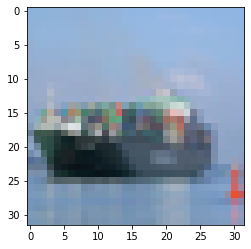

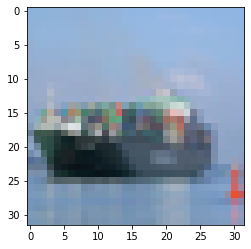

predicted ship
true ship
****************************************************************************************************


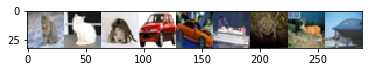

tensor([1.1869e-12, 1.7034e-14, 7.4477e-13, 5.6577e-12, 7.5836e-12, 1.0000e+00,
        2.2453e-12, 4.1726e-13, 5.9235e-13], device='cuda:0',
       dtype=torch.float64)


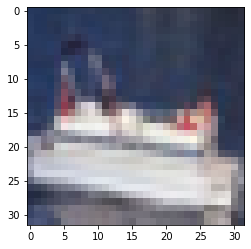

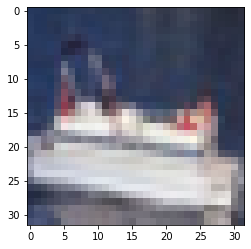

predicted ship
true ship
****************************************************************************************************


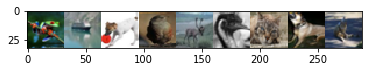

tensor([4.9456e-02, 3.6182e-01, 1.8558e-03, 4.3695e-04, 5.7380e-01, 1.0906e-03,
        8.8636e-03, 9.5845e-04, 1.7143e-03], device='cuda:0',
       dtype=torch.float64)


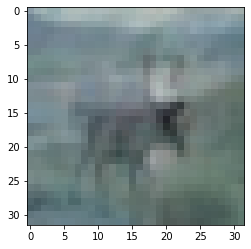

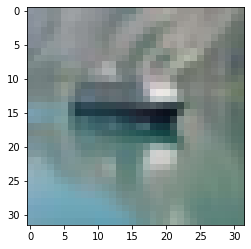

predicted ship
true ship
****************************************************************************************************


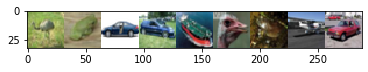

tensor([5.6606e-08, 3.2243e-08, 6.4743e-07, 3.0203e-06, 9.9998e-01, 8.1063e-08,
        4.9163e-06, 1.0123e-05, 6.4103e-07], device='cuda:0',
       dtype=torch.float64)


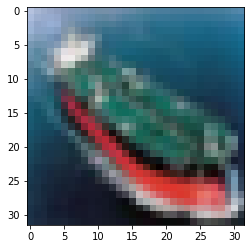

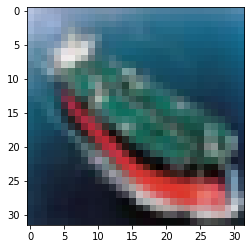

predicted ship
true ship
****************************************************************************************************


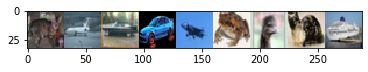

tensor([1.1308e-12, 3.3896e-14, 1.1881e-15, 3.4388e-13, 3.4160e-16, 8.9276e-18,
        2.8309e-14, 1.2241e-15, 1.0000e+00], device='cuda:0',
       dtype=torch.float64)


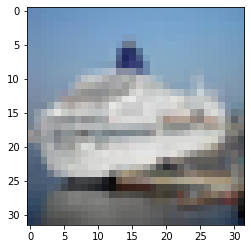

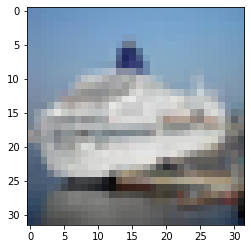

predicted ship
true ship
****************************************************************************************************


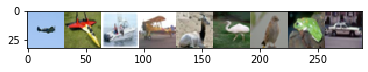

tensor([3.5373e-15, 1.5839e-14, 1.0000e+00, 1.3538e-09, 4.8632e-10, 1.6300e-13,
        1.1701e-12, 1.7320e-13, 1.7885e-10], device='cuda:0',
       dtype=torch.float64)


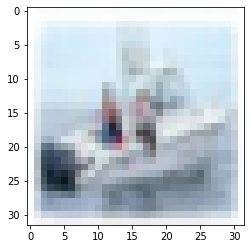

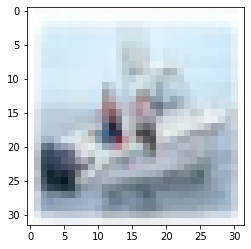

predicted ship
true ship
****************************************************************************************************


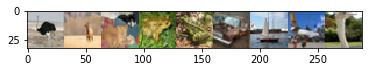

tensor([6.9102e-09, 1.8587e-06, 5.4588e-09, 2.4712e-08, 1.1979e-08, 1.9627e-06,
        1.0000e+00, 6.3067e-09, 3.4787e-07], device='cuda:0',
       dtype=torch.float64)


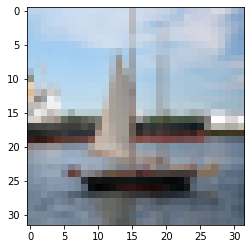

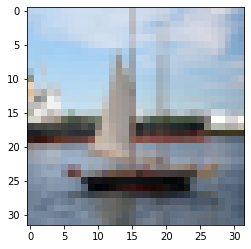

predicted ship
true ship
****************************************************************************************************


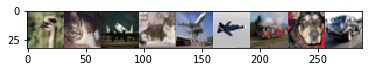

tensor([8.7129e-04, 8.4452e-05, 2.4935e-04, 3.0771e-02, 4.4451e-05, 1.4547e-04,
        9.6199e-01, 1.3664e-03, 4.4801e-03], device='cuda:0',
       dtype=torch.float64)


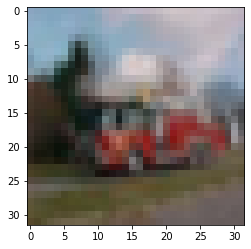

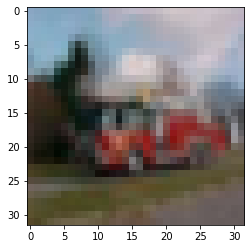

predicted truck
true truck
****************************************************************************************************


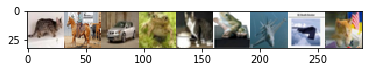

tensor([1.9486e-05, 9.8907e-01, 2.8330e-04, 1.4619e-04, 1.0531e-05, 3.8851e-06,
        1.8654e-04, 1.2665e-03, 9.0100e-03], device='cuda:0',
       dtype=torch.float64)


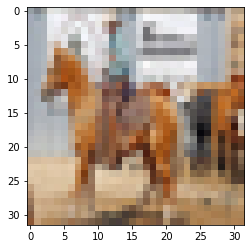

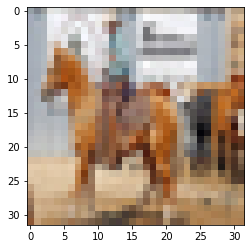

predicted horse
true horse
****************************************************************************************************


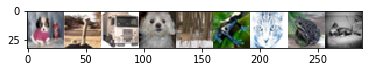

tensor([0.0540, 0.0016, 0.6064, 0.0099, 0.2049, 0.0187, 0.0040, 0.0380, 0.0625],
       device='cuda:0', dtype=torch.float64)


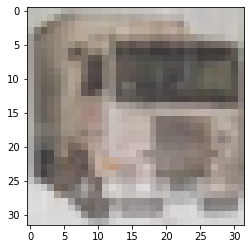

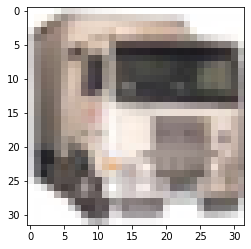

predicted truck
true truck
****************************************************************************************************


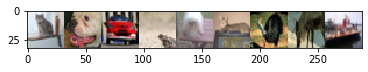

tensor([8.0980e-08, 1.0952e-09, 6.0342e-08, 6.1818e-08, 7.6745e-08, 5.3491e-10,
        4.6264e-12, 1.2346e-07, 1.0000e+00], device='cuda:0',
       dtype=torch.float64)


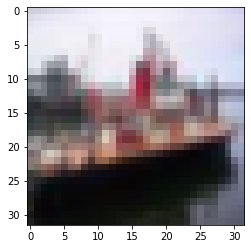

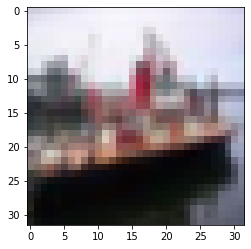

predicted ship
true ship
****************************************************************************************************


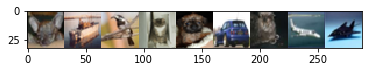

tensor([1.4297e-04, 9.9718e-01, 1.5793e-03, 1.4470e-05, 4.0255e-04, 3.3467e-04,
        9.6047e-06, 1.1791e-04, 2.2003e-04], device='cuda:0',
       dtype=torch.float64)


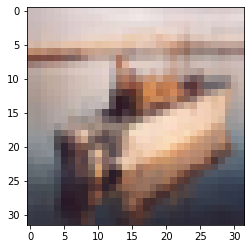

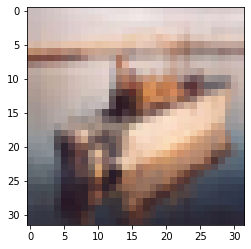

predicted ship
true ship
****************************************************************************************************


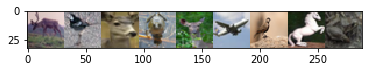

tensor([3.1038e-03, 4.3497e-04, 6.8604e-04, 2.3416e-03, 1.3703e-03, 4.5257e-06,
        9.8903e-01, 4.9697e-06, 3.0270e-03], device='cuda:0',
       dtype=torch.float64)


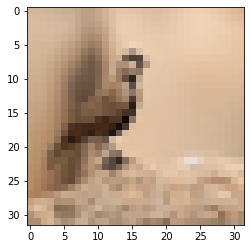

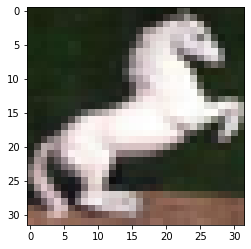

predicted ship
true horse
****************************************************************************************************


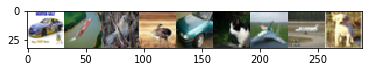

tensor([1.7720e-01, 3.0551e-02, 8.4560e-02, 1.5983e-05, 1.6653e-02, 7.3026e-04,
        6.7625e-01, 1.3230e-02, 8.1324e-04], device='cuda:0',
       dtype=torch.float64)


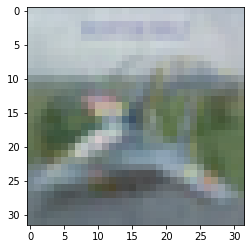

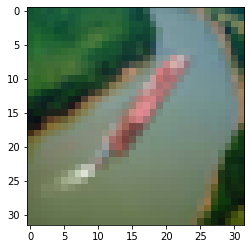

predicted ship
true ship
****************************************************************************************************


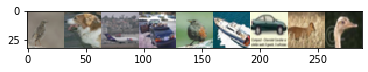

tensor([1.5958e-17, 8.1069e-17, 1.8343e-14, 1.2766e-17, 9.4139e-18, 1.0000e+00,
        3.7742e-18, 9.7895e-17, 6.6648e-17], device='cuda:0',
       dtype=torch.float64)


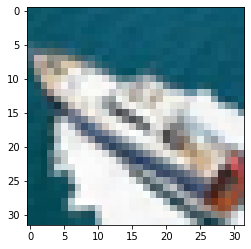

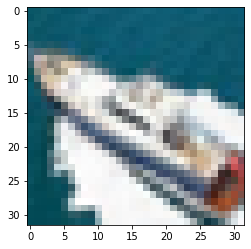

predicted ship
true ship
****************************************************************************************************


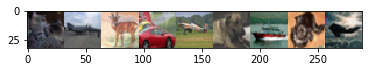

tensor([1.6028e-09, 5.6657e-10, 7.7836e-10, 1.8572e-08, 4.6305e-07, 1.8722e-08,
        1.0000e+00, 8.5357e-11, 2.7359e-10], device='cuda:0',
       dtype=torch.float64)


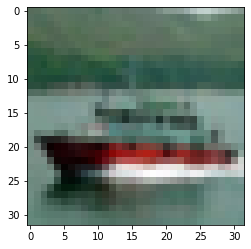

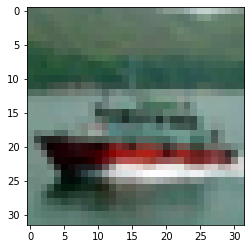

predicted ship
true ship
****************************************************************************************************


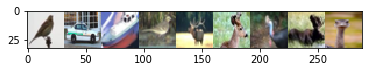

tensor([4.1864e-09, 6.3294e-07, 9.9950e-01, 4.1197e-04, 6.7497e-07, 8.0886e-05,
        4.0834e-06, 5.0368e-09, 1.0094e-07], device='cuda:0',
       dtype=torch.float64)


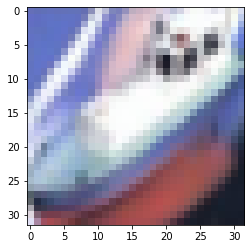

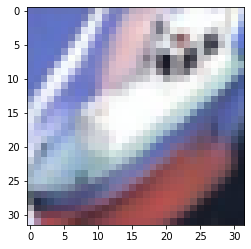

predicted ship
true ship
****************************************************************************************************


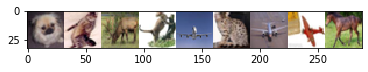

tensor([1.1388e-08, 2.9744e-07, 1.8955e-04, 2.5134e-09, 3.1874e-08, 3.1095e-10,
        9.2712e-07, 5.9421e-11, 9.9981e-01], device='cuda:0',
       dtype=torch.float64)


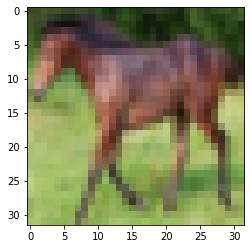

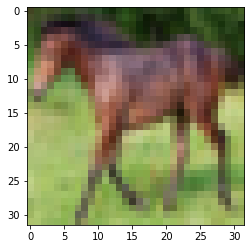

predicted horse
true horse
****************************************************************************************************


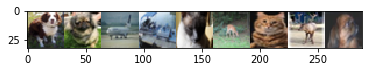

tensor([1.4130e-03, 4.6883e-07, 2.1428e-06, 9.9829e-01, 3.7594e-05, 4.2271e-06,
        2.6939e-06, 6.6937e-07, 2.4518e-04], device='cuda:0',
       dtype=torch.float64)


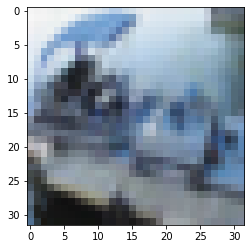

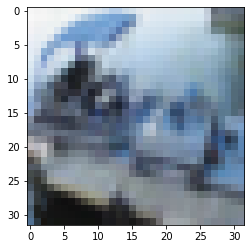

predicted ship
true ship
****************************************************************************************************


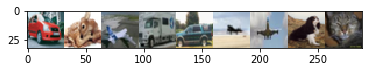

tensor([9.9997e-01, 5.7390e-07, 2.1543e-06, 1.4081e-05, 1.1844e-05, 1.5667e-09,
        1.0053e-08, 1.4828e-07, 7.9363e-08], device='cuda:0',
       dtype=torch.float64)


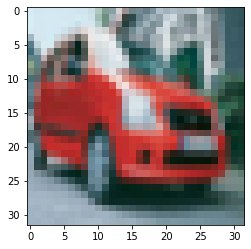

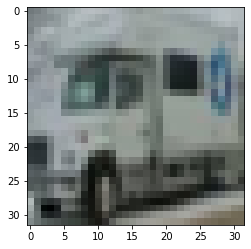

predicted truck
true truck
****************************************************************************************************


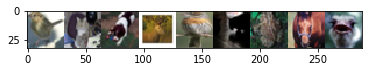

tensor([1.6628e-04, 7.1485e-02, 1.5768e-07, 8.8816e-02, 1.5977e-03, 4.0392e-01,
        6.4927e-03, 1.1415e-02, 4.1610e-01], device='cuda:0',
       dtype=torch.float64)


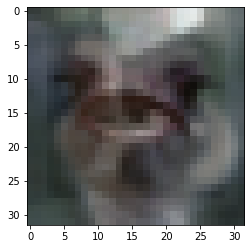

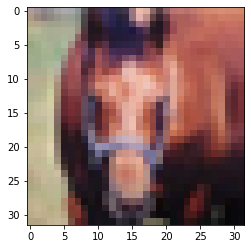

predicted horse
true horse
****************************************************************************************************


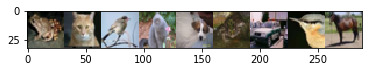

tensor([1.7901e-25, 3.4420e-22, 1.9792e-23, 2.3453e-21, 5.3846e-24, 1.8353e-21,
        2.4607e-19, 7.3964e-30, 1.0000e+00], device='cuda:0',
       dtype=torch.float64)


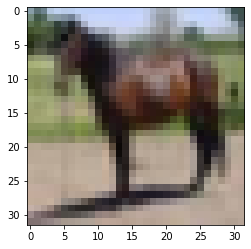

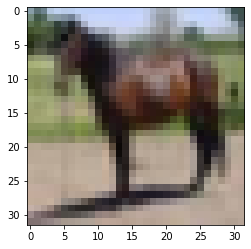

predicted horse
true horse
****************************************************************************************************


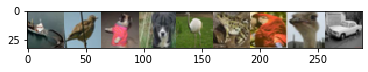

tensor([9.9995e-01, 2.0097e-08, 8.4332e-07, 8.4961e-06, 3.5909e-05, 2.1619e-06,
        1.0715e-07, 3.5190e-08, 6.9607e-10], device='cuda:0',
       dtype=torch.float64)


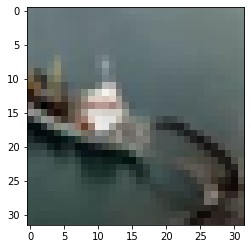

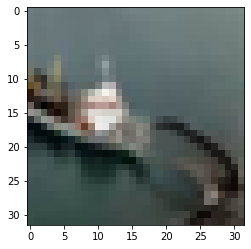

predicted ship
true ship
****************************************************************************************************


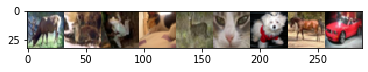

tensor([3.9976e-09, 7.2054e-09, 4.6730e-09, 2.3807e-08, 7.6457e-09, 7.3588e-10,
        1.9157e-10, 1.0000e+00, 3.2452e-10], device='cuda:0',
       dtype=torch.float64)


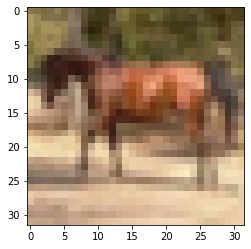

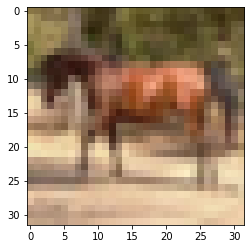

predicted horse
true horse
****************************************************************************************************


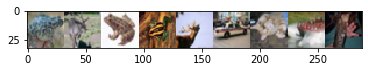

tensor([1.3431e-02, 9.1408e-02, 2.5030e-05, 7.7477e-05, 1.7190e-03, 8.9279e-01,
        1.2473e-04, 2.9234e-04, 1.3500e-04], device='cuda:0',
       dtype=torch.float64)


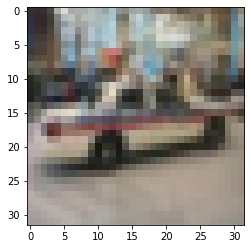

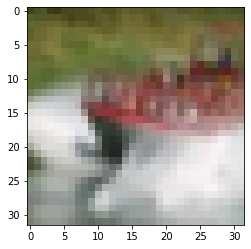

predicted ship
true ship
****************************************************************************************************


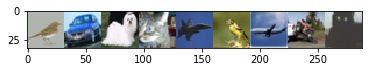

tensor([1.0552e-01, 1.7931e-01, 7.7470e-09, 2.8443e-03, 2.4025e-04, 9.2840e-03,
        4.3933e-04, 5.5239e-03, 6.9684e-01], device='cuda:0',
       dtype=torch.float64)


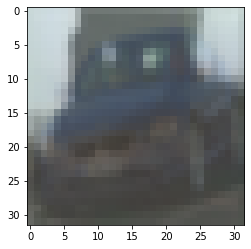

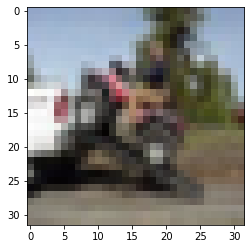

predicted truck
true truck
****************************************************************************************************


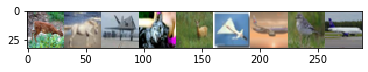

tensor([0.1391, 0.5482, 0.0526, 0.0019, 0.0853, 0.0237, 0.0080, 0.1383, 0.0029],
       device='cuda:0', dtype=torch.float64)


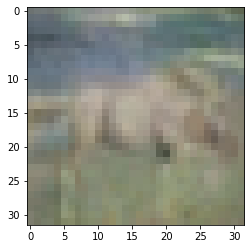

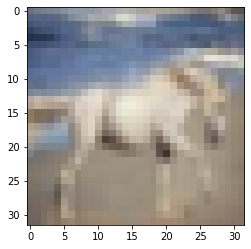

predicted horse
true horse
****************************************************************************************************


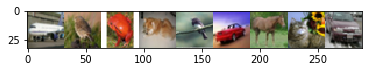

tensor([9.3683e-03, 1.3407e-03, 8.1808e-03, 4.1694e-03, 1.6397e-02, 1.5705e-01,
        7.9349e-01, 9.5085e-03, 4.8973e-04], device='cuda:0',
       dtype=torch.float64)


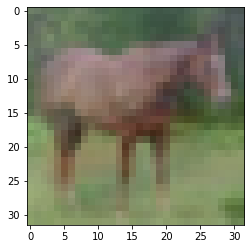

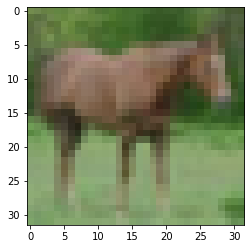

predicted horse
true horse
****************************************************************************************************


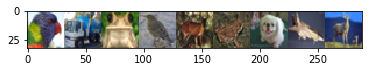

tensor([4.0786e-04, 6.4406e-01, 4.6353e-03, 4.2759e-02, 2.4191e-01, 3.4193e-03,
        8.5942e-04, 6.1526e-02, 4.2297e-04], device='cuda:0',
       dtype=torch.float64)


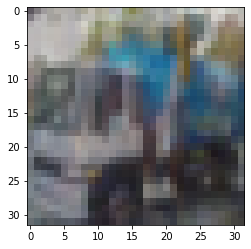

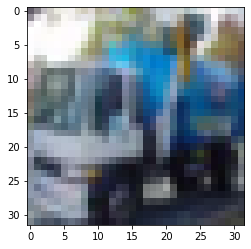

predicted truck
true truck
****************************************************************************************************


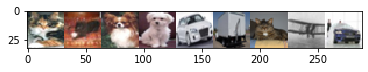

tensor([4.9708e-04, 1.8796e-01, 6.8859e-04, 5.5496e-03, 4.7906e-03, 6.8471e-01,
        1.3965e-04, 3.0491e-03, 1.1262e-01], device='cuda:0',
       dtype=torch.float64)


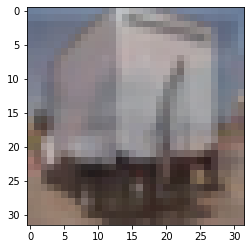

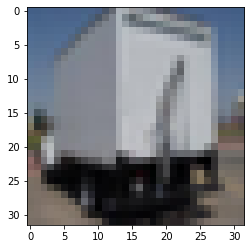

predicted truck
true truck
****************************************************************************************************


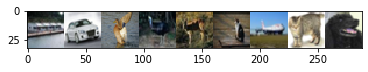

tensor([9.9977e-01, 1.4393e-05, 2.1804e-06, 5.0255e-05, 6.6116e-06, 1.4163e-05,
        7.7960e-07, 6.0407e-05, 8.5836e-05], device='cuda:0',
       dtype=torch.float64)


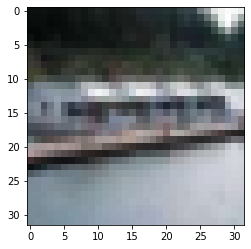

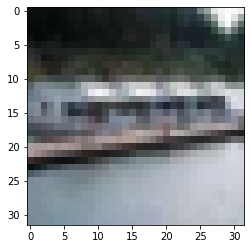

predicted ship
true ship
****************************************************************************************************


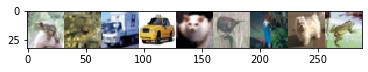

tensor([2.0645e-01, 3.9111e-03, 2.8865e-03, 5.4059e-01, 1.8328e-02, 7.1248e-03,
        8.8659e-02, 1.3181e-01, 2.4633e-04], device='cuda:0',
       dtype=torch.float64)


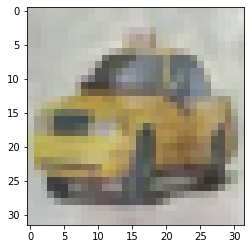

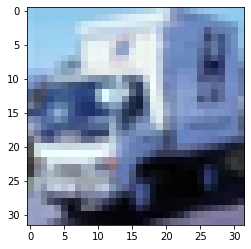

predicted truck
true truck
****************************************************************************************************


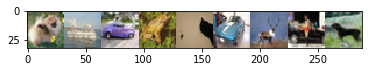

tensor([1.0071e-09, 1.0000e+00, 3.6894e-09, 4.9374e-10, 6.1542e-12, 1.2203e-09,
        2.2279e-13, 6.2955e-08, 2.0579e-11], device='cuda:0',
       dtype=torch.float64)


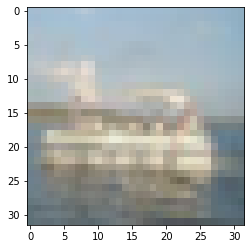

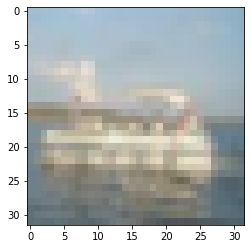

predicted ship
true ship
****************************************************************************************************


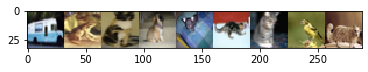

tensor([2.2779e-02, 5.6412e-04, 8.9347e-01, 2.8521e-03, 8.4111e-06, 1.2790e-02,
        4.1814e-03, 5.6501e-03, 5.7710e-02], device='cuda:0',
       dtype=torch.float64)


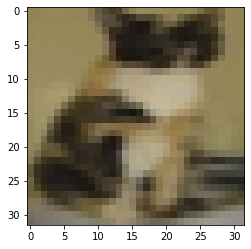

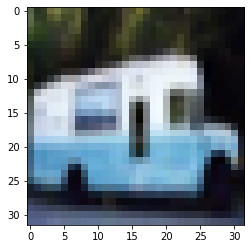

predicted truck
true truck
****************************************************************************************************


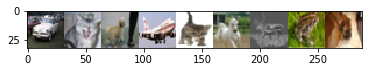

tensor([4.9892e-02, 8.3845e-02, 1.9332e-05, 6.4799e-02, 1.7725e-02, 5.8058e-01,
        1.4225e-01, 6.0336e-02, 5.4876e-04], device='cuda:0',
       dtype=torch.float64)


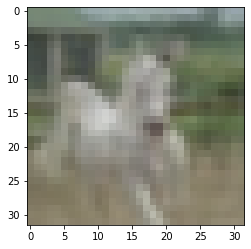

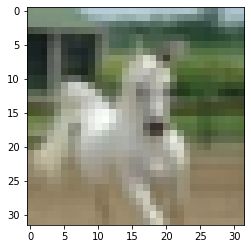

predicted horse
true horse
****************************************************************************************************


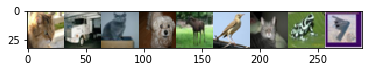

tensor([0.0402, 0.1130, 0.7599, 0.0331, 0.0313, 0.0016, 0.0027, 0.0061, 0.0120],
       device='cuda:0', dtype=torch.float64)


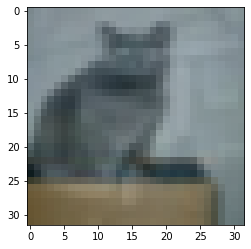

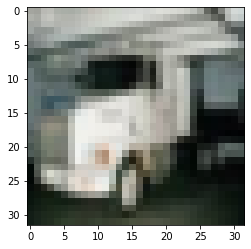

predicted truck
true truck
****************************************************************************************************


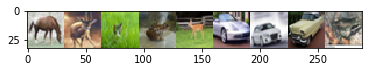

tensor([1.0000e+00, 5.7966e-09, 4.2864e-11, 6.2258e-10, 2.6432e-09, 5.8383e-09,
        1.9320e-09, 2.9346e-09, 2.3169e-08], device='cuda:0',
       dtype=torch.float64)


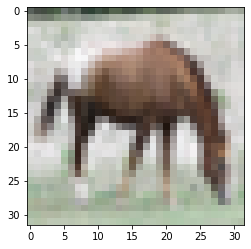

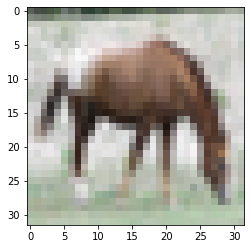

predicted horse
true horse
****************************************************************************************************


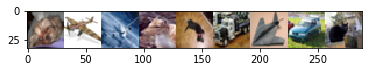

tensor([2.2420e-03, 6.6940e-05, 1.1349e-03, 6.9667e-02, 7.7581e-05, 9.0998e-01,
        1.0432e-03, 4.4724e-04, 1.5344e-02], device='cuda:0',
       dtype=torch.float64)


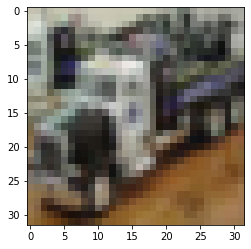

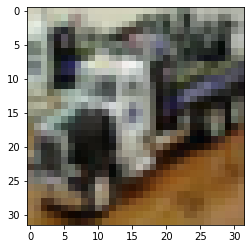

predicted truck
true truck
****************************************************************************************************


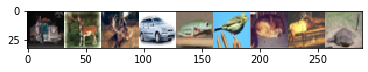

tensor([1.4927e-04, 1.1145e-02, 2.0446e-01, 9.4298e-04, 1.1342e-01, 9.3809e-10,
        1.4542e-02, 2.6202e-02, 6.2914e-01], device='cuda:0',
       dtype=torch.float64)


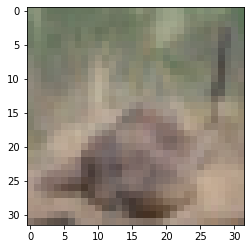

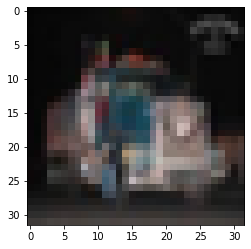

predicted truck
true truck
****************************************************************************************************


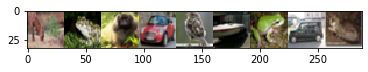

tensor([8.5776e-07, 7.4184e-08, 9.2281e-08, 9.4680e-06, 9.2680e-06, 9.9990e-01,
        6.4711e-05, 1.0897e-05, 2.4740e-06], device='cuda:0',
       dtype=torch.float64)


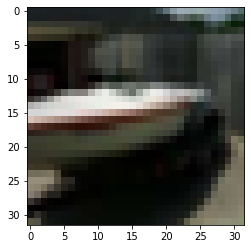

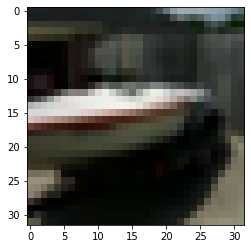

predicted ship
true ship
****************************************************************************************************


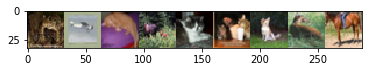

tensor([5.5042e-05, 1.2726e-07, 5.2656e-06, 1.2598e-07, 4.7988e-09, 1.2642e-06,
        9.7294e-05, 5.6580e-06, 9.9984e-01], device='cuda:0',
       dtype=torch.float64)


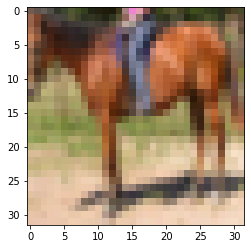

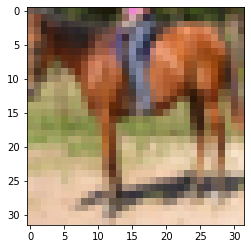

predicted horse
true horse
****************************************************************************************************


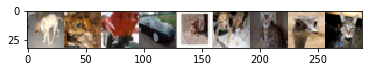

tensor([6.8786e-05, 3.2752e-07, 9.9943e-01, 1.7106e-05, 1.9994e-06, 7.1644e-08,
        4.8015e-04, 3.5830e-07, 2.3488e-06], device='cuda:0',
       dtype=torch.float64)


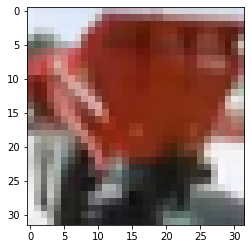

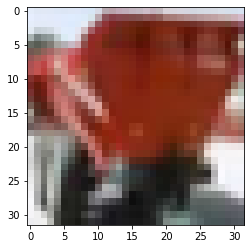

predicted truck
true truck
****************************************************************************************************


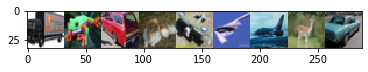

tensor([3.5895e-01, 2.7270e-02, 3.1886e-02, 1.8398e-03, 5.2285e-01, 2.0555e-04,
        6.9783e-05, 1.5127e-03, 5.5408e-02], device='cuda:0',
       dtype=torch.float64)


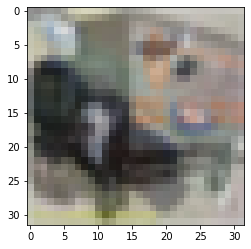

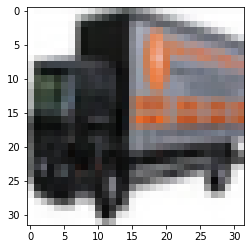

predicted truck
true truck
****************************************************************************************************


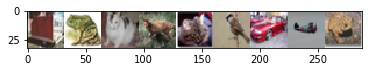

tensor([6.9874e-01, 5.2765e-03, 3.5173e-05, 6.2706e-03, 2.2983e-04, 2.6338e-03,
        2.8507e-01, 1.3302e-03, 4.1889e-04], device='cuda:0',
       dtype=torch.float64)


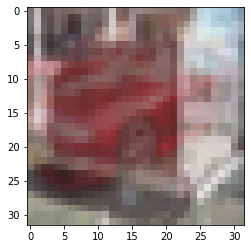

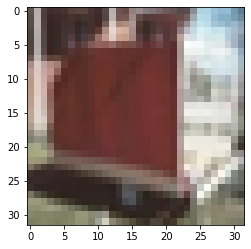

predicted truck
true truck
****************************************************************************************************


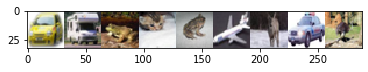

tensor([9.9916e-01, 2.9962e-04, 2.4453e-04, 3.3854e-12, 1.2445e-05, 3.3108e-07,
        5.7666e-07, 2.7114e-04, 9.0235e-06], device='cuda:0',
       dtype=torch.float64)


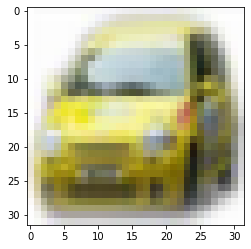

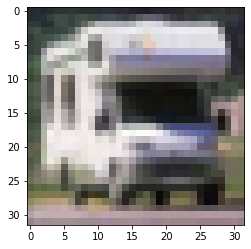

predicted truck
true truck
****************************************************************************************************


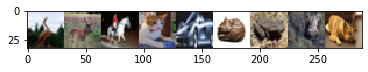

tensor([1.3929e-05, 1.2329e-06, 9.9902e-01, 1.6608e-04, 1.6464e-04, 2.6577e-05,
        1.6117e-08, 5.8470e-04, 1.7900e-05], device='cuda:0',
       dtype=torch.float64)


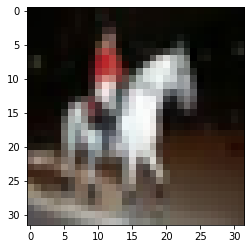

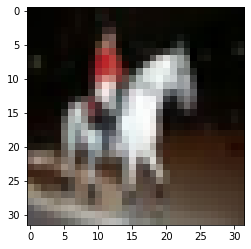

predicted horse
true horse
****************************************************************************************************


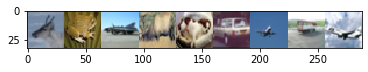

tensor([2.2737e-03, 3.9789e-02, 3.5279e-03, 8.5252e-01, 2.8158e-02, 6.3185e-02,
        4.4991e-07, 8.0787e-03, 2.4698e-03], device='cuda:0',
       dtype=torch.float64)


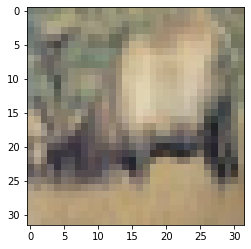

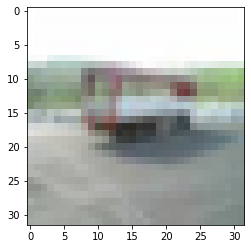

predicted truck
true truck
****************************************************************************************************


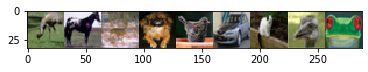

tensor([1.1779e-09, 1.0000e+00, 7.9467e-11, 2.6127e-10, 1.6331e-08, 3.6822e-09,
        5.9857e-09, 5.8028e-10, 2.1651e-10], device='cuda:0',
       dtype=torch.float64)


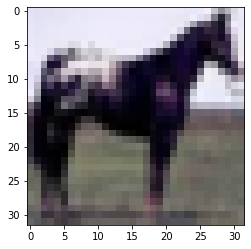

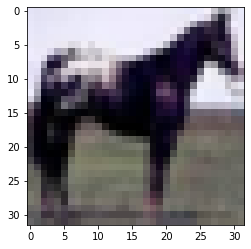

predicted horse
true horse
****************************************************************************************************


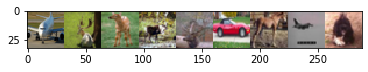

tensor([6.1496e-02, 2.6642e-02, 1.1498e-01, 3.3426e-04, 9.5227e-03, 4.2191e-02,
        6.8753e-01, 4.4816e-03, 5.2817e-02], device='cuda:0',
       dtype=torch.float64)


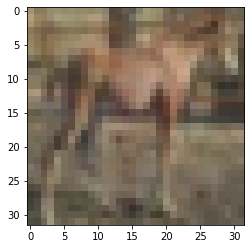

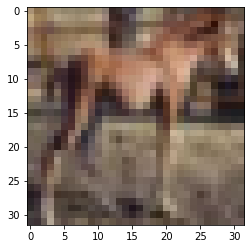

predicted horse
true horse
****************************************************************************************************


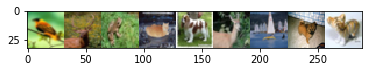

tensor([7.9008e-13, 7.7742e-10, 1.0448e-10, 1.2209e-09, 4.0489e-09, 7.0801e-12,
        1.0000e+00, 6.4149e-11, 5.7543e-12], device='cuda:0',
       dtype=torch.float64)


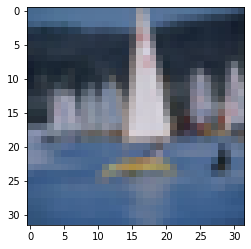

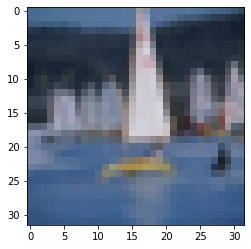

predicted ship
true ship
Accuracy of the network on the 30000 train images: 97 %
total correct 29214
total train set images 30000
focus_true_pred_true 36
focus_false_pred_true 13
focus_true_pred_false 0
focus_false_pred_false 1
argmax_more_than_half 49
argmax_less_than_half 1


In [155]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

train_loader1 = DataLoader( msd,batch_size= batch ,shuffle=False)
with torch.no_grad():
  for data in train_loader1:
    inputs, labels , fore_idx = data
    inputs,labels = inputs.to("cuda"),labels.to("cuda") 
    avg_images , alphas = where_net(inputs)
    outputs = what_net(avg_images)

    _, predicted = torch.max(outputs.data, 1)

    if flag==1 :
      for j in range (50):
        print("*"*100)
        img1 = torch.cat((inputs[j][0], inputs[j][1], inputs[j][2], inputs[j][3], inputs[j][4], inputs[j][5], inputs[j][6], inputs[j][7], inputs[j][8]) , 2)
        display(img1.cpu())

        print(alphas[j])

        img2 = avg_images[j]
        display(img2.cpu())

        img3 = inputs[j][fore_idx[j]]
        display(img3.cpu())

        print("predicted", classes[predicted[j]+7])
        print("true", classes[labels[j]+7])
        
        focus = torch.argmax(alphas[j])
      
        if(alphas[j][focus] >= 0.5):
          argmax_more_than_half +=1
        else:
          argmax_less_than_half +=1

        if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1

        elif(focus != fore_idx[j] and predicted[j] == labels[j]):
          focus_false_pred_true +=1

        elif(focus == fore_idx[j] and predicted[j] != labels[j]):
          focus_true_pred_false +=1

        elif(focus != fore_idx[j] and predicted[j] != labels[j]):
          focus_false_pred_false +=1

      flag =0

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true",focus_true_pred_true)
print("focus_false_pred_true",focus_false_pred_true )
print("focus_true_pred_false",focus_true_pred_false )
print("focus_false_pred_false",focus_false_pred_false)

print("argmax_more_than_half",argmax_more_than_half)
print("argmax_less_than_half",argmax_less_than_half)

In [0]:
test_images =[]        #list of mosaic images, each mosaic image is saved as laist of 9 images
fore_idx_test =[]                   #list of indexes at which foreground image is present in a mosaic image                
test_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(10000):
    bg_idx = np.random.randint(0,35000,8)
    fg_idx = np.random.randint(0,15000)
    fg = np.random.randint(0,9)
    fore_idx_test.append(fg)
    image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
    test_images.append(image_list)
    test_label.append(label)

In [0]:
# test_data = MosaicDataset(test_images,test_label,)
# test_loader = DataLoader( test_data,batch_size= batch ,shuffle=False)

6


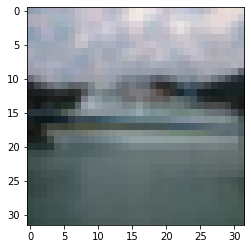

ship


In [158]:
print(fore_idx_test[0])
imshow(test_images[0][fore_idx_test[0]])
print(classes[test_label[0]+7])

****************************************************************************************************


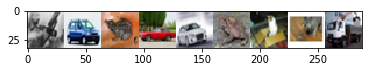

tensor([4.7434e-02, 4.2816e-04, 4.5519e-04, 2.0207e-04, 2.7671e-04, 3.8111e-03,
        6.0578e-03, 3.7450e-02, 9.0388e-01], device='cuda:0',
       dtype=torch.float64)


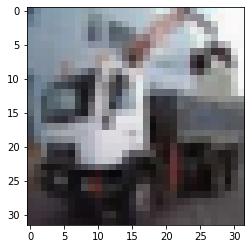

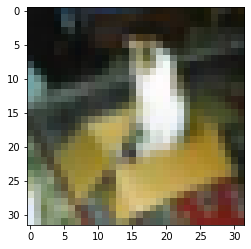

predicted truck
true truck
****************************************************************************************************


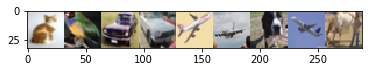

tensor([3.1643e-02, 9.0879e-06, 6.1996e-05, 7.1658e-04, 1.3911e-03, 7.2342e-08,
        3.0619e-03, 2.8165e-05, 9.6309e-01], device='cuda:0',
       dtype=torch.float64)


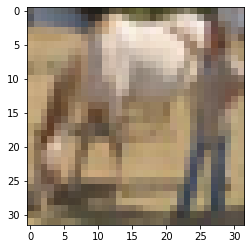

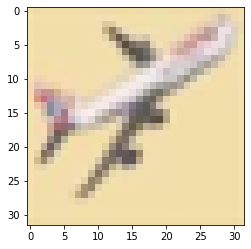

predicted horse
true horse
****************************************************************************************************


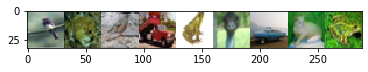

tensor([3.5595e-03, 1.2534e-07, 1.4859e-03, 9.9312e-01, 4.3918e-05, 1.8528e-07,
        5.8490e-04, 3.3399e-04, 8.7442e-04], device='cuda:0',
       dtype=torch.float64)


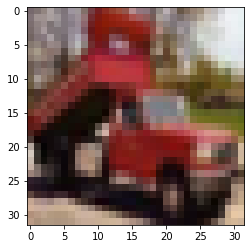

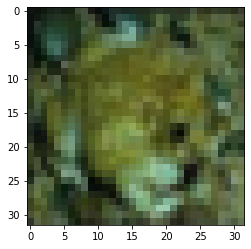

predicted truck
true truck
****************************************************************************************************


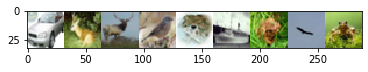

tensor([3.1175e-10, 2.9544e-11, 9.5523e-11, 3.1827e-09, 1.9957e-11, 1.0000e+00,
        6.4914e-09, 7.0153e-14, 9.9042e-09], device='cuda:0',
       dtype=torch.float64)


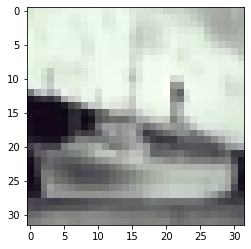

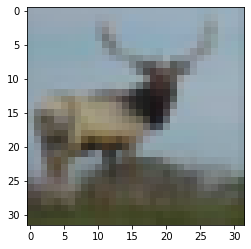

predicted ship
true ship
****************************************************************************************************


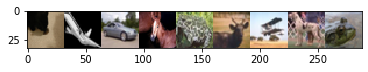

tensor([5.1079e-05, 6.7102e-02, 5.0652e-02, 8.7671e-03, 1.5038e-03, 1.8208e-01,
        5.5840e-02, 3.0159e-02, 6.0384e-01], device='cuda:0',
       dtype=torch.float64)


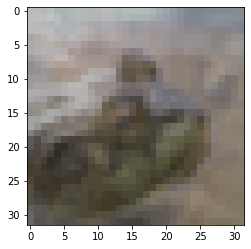

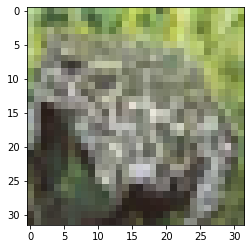

predicted truck
true horse
****************************************************************************************************


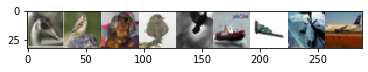

tensor([1.7421e-03, 1.0256e-06, 6.7124e-03, 1.8995e-09, 1.0718e-05, 9.9153e-01,
        2.7018e-08, 2.7200e-06, 1.1595e-07], device='cuda:0',
       dtype=torch.float64)


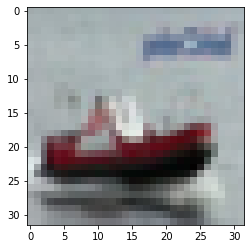

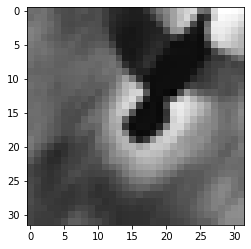

predicted ship
true ship
****************************************************************************************************


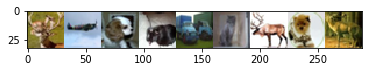

tensor([2.1197e-03, 5.1699e-05, 7.3484e-02, 3.5257e-04, 7.5520e-02, 1.8418e-02,
        7.9948e-01, 2.7134e-02, 3.4426e-03], device='cuda:0',
       dtype=torch.float64)


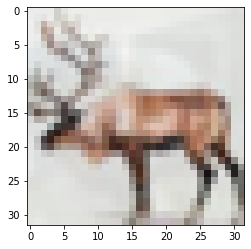

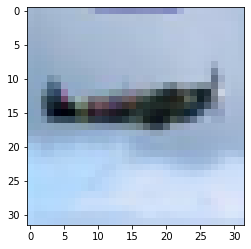

predicted horse
true truck
****************************************************************************************************


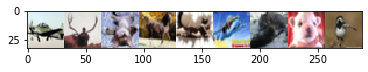

tensor([6.0105e-06, 1.8460e-04, 1.2481e-01, 5.5685e-01, 1.7808e-03, 4.3484e-07,
        2.3798e-01, 8.0914e-04, 7.7565e-02], device='cuda:0',
       dtype=torch.float64)


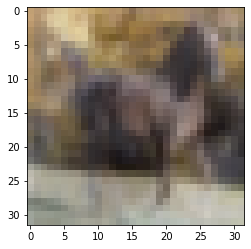

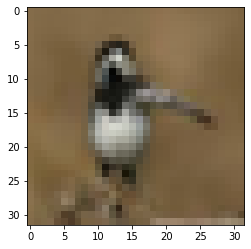

predicted truck
true horse
****************************************************************************************************


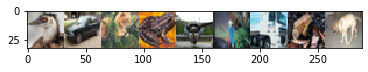

tensor([7.2713e-02, 1.9293e-02, 4.6059e-04, 2.9203e-02, 7.5558e-01, 2.9230e-02,
        5.2708e-02, 1.2615e-02, 2.8200e-02], device='cuda:0',
       dtype=torch.float64)


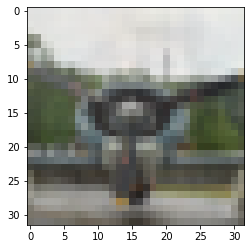

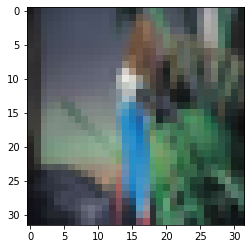

predicted truck
true truck
****************************************************************************************************


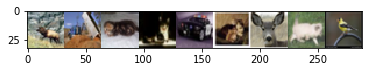

tensor([1.6297e-04, 1.3380e-02, 2.0969e-03, 4.0060e-04, 9.7345e-01, 4.8724e-04,
        8.6103e-03, 1.1254e-05, 1.4002e-03], device='cuda:0',
       dtype=torch.float64)


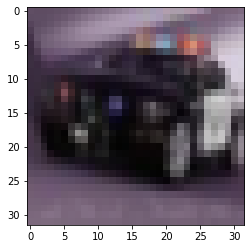

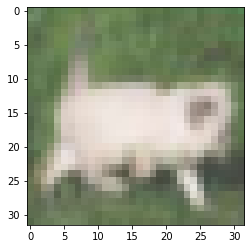

predicted truck
true truck
****************************************************************************************************


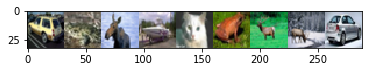

tensor([2.8428e-03, 8.7274e-04, 8.5643e-07, 9.9158e-01, 5.5420e-05, 2.4169e-03,
        2.8720e-06, 2.5600e-05, 2.2063e-03], device='cuda:0',
       dtype=torch.float64)


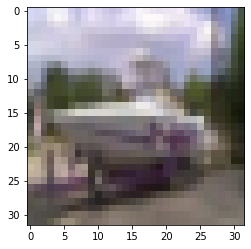

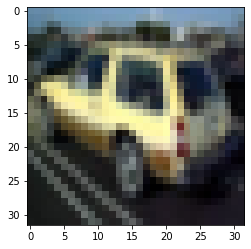

predicted truck
true ship
****************************************************************************************************


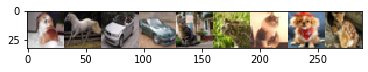

tensor([7.6950e-03, 6.4664e-02, 1.7863e-03, 1.3757e-04, 2.5584e-02, 2.7976e-03,
        3.8114e-02, 8.5001e-01, 9.2077e-03], device='cuda:0',
       dtype=torch.float64)


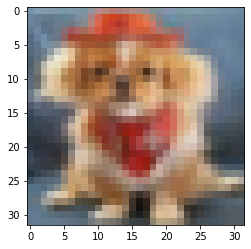

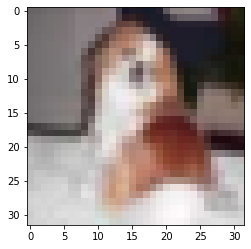

predicted truck
true horse
****************************************************************************************************


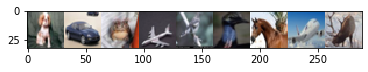

tensor([0.0022, 0.9324, 0.0300, 0.0046, 0.0016, 0.0226, 0.0036, 0.0011, 0.0020],
       device='cuda:0', dtype=torch.float64)


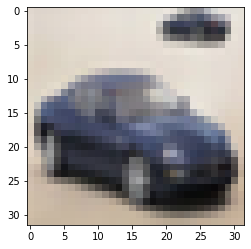

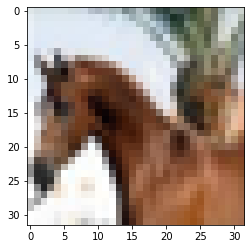

predicted truck
true horse
****************************************************************************************************


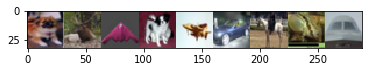

tensor([4.7022e-05, 9.8362e-02, 2.0528e-02, 3.9754e-06, 6.8447e-09, 1.3145e-05,
        8.8045e-01, 2.3000e-05, 5.7031e-04], device='cuda:0',
       dtype=torch.float64)


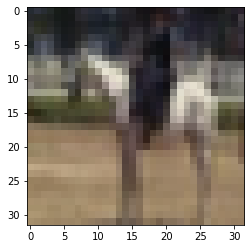

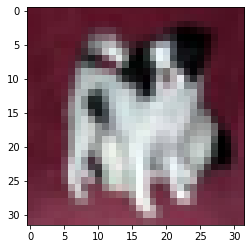

predicted horse
true horse
****************************************************************************************************


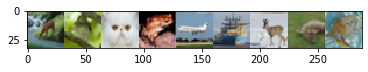

tensor([8.9985e-06, 9.1446e-06, 1.5726e-07, 2.5831e-05, 5.1374e-05, 9.9497e-01,
        1.5068e-04, 4.1873e-03, 5.9371e-04], device='cuda:0',
       dtype=torch.float64)


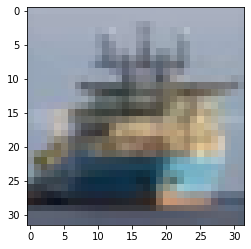

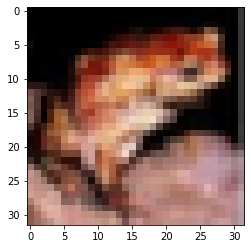

predicted ship
true ship
****************************************************************************************************


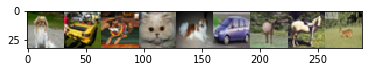

tensor([1.3311e-06, 2.0382e-10, 2.9117e-07, 2.7374e-07, 1.0846e-06, 6.3143e-07,
        2.4031e-04, 9.9965e-01, 1.0859e-04], device='cuda:0',
       dtype=torch.float64)


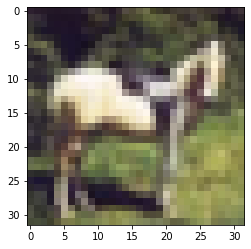

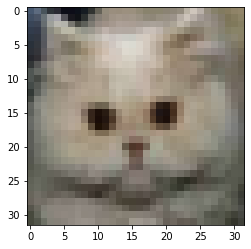

predicted horse
true horse
****************************************************************************************************


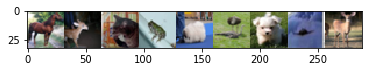

tensor([1.0000e+00, 3.1786e-08, 1.1745e-08, 7.1520e-09, 1.2206e-09, 6.0101e-07,
        9.7079e-10, 3.5848e-10, 7.9377e-07], device='cuda:0',
       dtype=torch.float64)


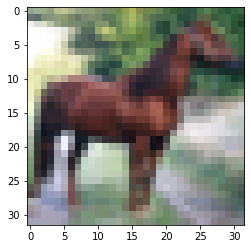

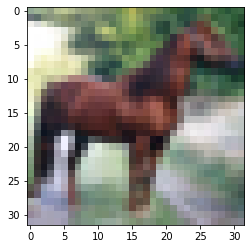

predicted horse
true horse
****************************************************************************************************


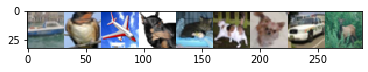

tensor([9.9994e-01, 2.1194e-06, 9.4739e-09, 4.6998e-05, 7.9310e-10, 2.2834e-10,
        8.1401e-06, 4.3798e-07, 3.0057e-08], device='cuda:0',
       dtype=torch.float64)


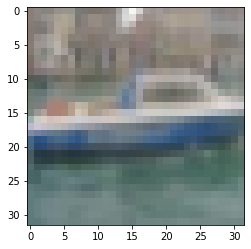

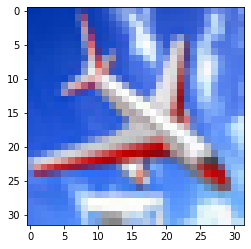

predicted ship
true ship
****************************************************************************************************


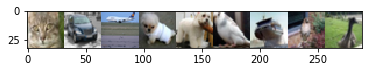

tensor([5.2784e-03, 6.8983e-03, 5.0106e-04, 1.7635e-04, 5.7120e-03, 6.0181e-04,
        2.5464e-04, 9.0644e-01, 7.4137e-02], device='cuda:0',
       dtype=torch.float64)


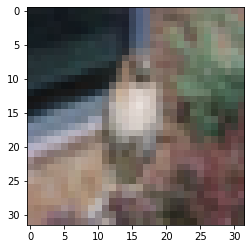

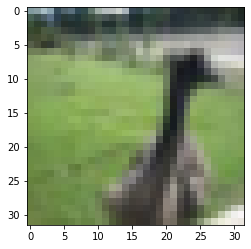

predicted ship
true ship
****************************************************************************************************


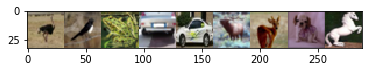

tensor([1.0890e-02, 5.0666e-04, 6.0660e-01, 4.8440e-02, 6.8048e-02, 9.5428e-04,
        5.4228e-03, 2.5873e-01, 4.1311e-04], device='cuda:0',
       dtype=torch.float64)


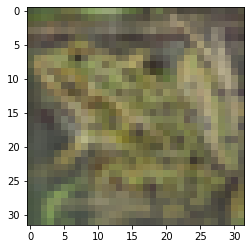

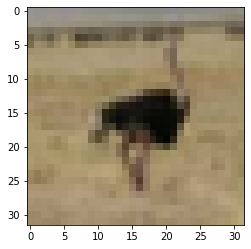

predicted horse
true horse
****************************************************************************************************


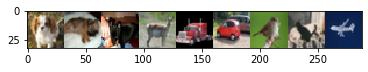

tensor([1.2793e-04, 3.5986e-02, 2.1176e-03, 9.7799e-02, 8.9124e-02, 9.8956e-03,
        7.5917e-01, 1.5096e-04, 5.6334e-03], device='cuda:0',
       dtype=torch.float64)


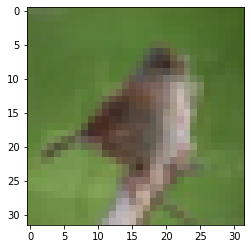

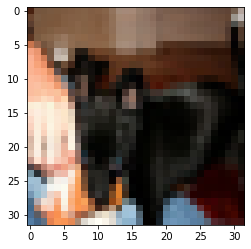

predicted horse
true truck
****************************************************************************************************


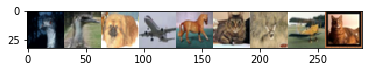

tensor([7.6394e-06, 2.3161e-05, 3.3232e-06, 1.6345e-06, 3.5612e-03, 3.5622e-06,
        6.2165e-07, 9.9640e-01, 1.0428e-06], device='cuda:0',
       dtype=torch.float64)


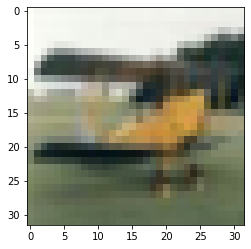

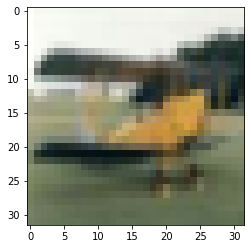

predicted horse
true horse
****************************************************************************************************


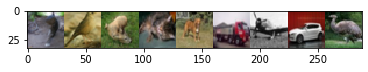

tensor([1.3908e-03, 1.3765e-02, 1.4417e-03, 9.9970e-03, 4.3763e-03, 9.5783e-01,
        3.8286e-03, 9.3342e-07, 7.3687e-03], device='cuda:0',
       dtype=torch.float64)


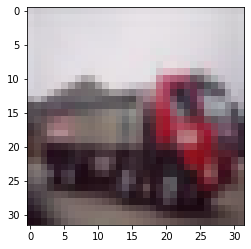

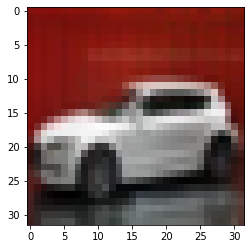

predicted truck
true truck
****************************************************************************************************


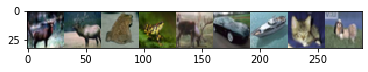

tensor([1.8352e-06, 9.7658e-05, 1.6123e-06, 7.2117e-06, 1.1573e-06, 4.0894e-05,
        9.9856e-01, 1.3466e-05, 1.2766e-03], device='cuda:0',
       dtype=torch.float64)


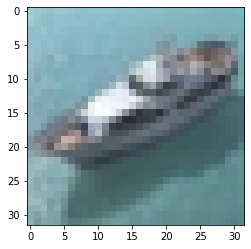

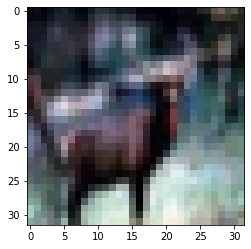

predicted ship
true ship
****************************************************************************************************


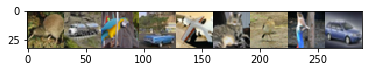

tensor([0.2921, 0.0008, 0.2702, 0.1915, 0.0546, 0.0159, 0.1720, 0.0006, 0.0023],
       device='cuda:0', dtype=torch.float64)


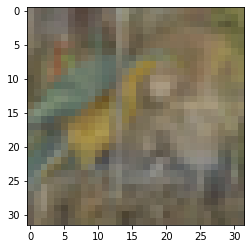

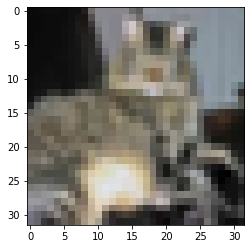

predicted horse
true truck
****************************************************************************************************


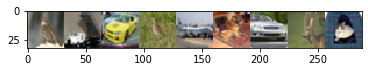

tensor([1.3738e-02, 3.2831e-05, 4.1053e-04, 1.0742e-02, 1.0189e-02, 5.3234e-01,
        2.6479e-01, 1.6697e-01, 7.8782e-04], device='cuda:0',
       dtype=torch.float64)


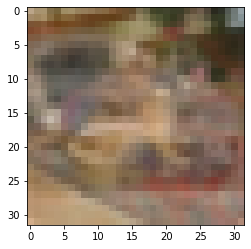

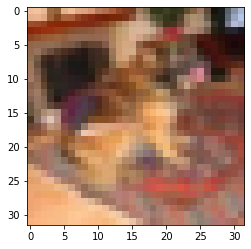

predicted horse
true truck
****************************************************************************************************


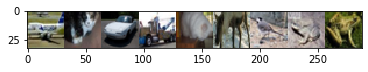

tensor([6.2049e-04, 1.3530e-02, 6.6352e-05, 2.3285e-01, 6.1185e-01, 7.8183e-02,
        2.0745e-02, 4.0714e-02, 1.4428e-03], device='cuda:0',
       dtype=torch.float64)


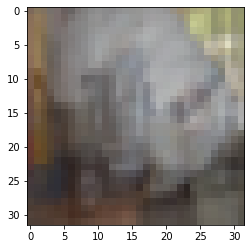

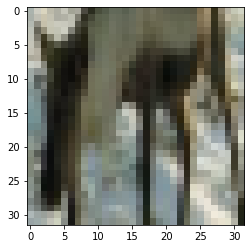

predicted truck
true truck
****************************************************************************************************


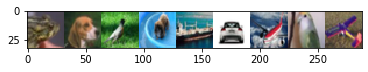

tensor([4.6788e-09, 5.0277e-08, 1.3338e-07, 4.4193e-10, 1.0000e+00, 6.8558e-12,
        3.0292e-11, 9.3606e-07, 1.8928e-07], device='cuda:0',
       dtype=torch.float64)


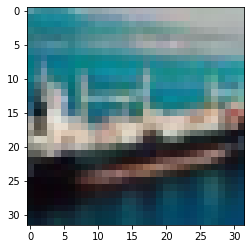

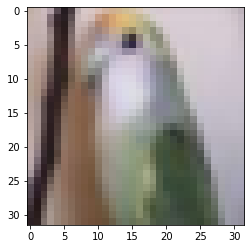

predicted ship
true ship
****************************************************************************************************


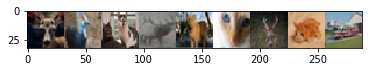

tensor([0.0016, 0.0013, 0.3434, 0.0251, 0.0725, 0.1666, 0.2470, 0.0604, 0.0820],
       device='cuda:0', dtype=torch.float64)


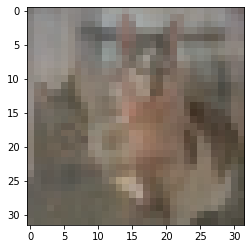

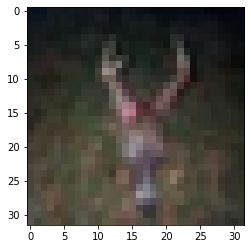

predicted truck
true truck
****************************************************************************************************


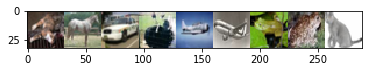

tensor([5.2198e-05, 9.9773e-01, 1.5349e-04, 2.4940e-04, 3.6713e-06, 2.2260e-04,
        2.2651e-05, 1.2183e-04, 1.4483e-03], device='cuda:0',
       dtype=torch.float64)


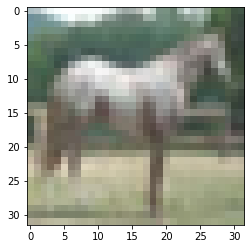

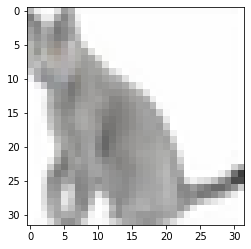

predicted horse
true horse
****************************************************************************************************


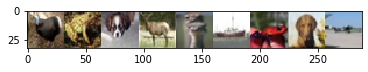

tensor([2.3056e-09, 8.7505e-12, 7.6713e-11, 5.0645e-09, 4.6680e-10, 1.0000e+00,
        2.3832e-10, 2.2043e-13, 7.6812e-11], device='cuda:0',
       dtype=torch.float64)


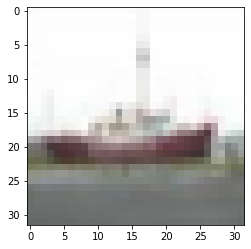

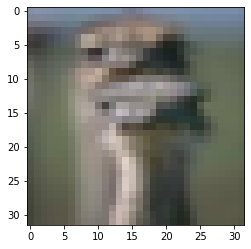

predicted ship
true ship
****************************************************************************************************


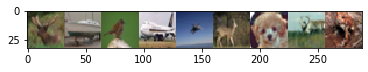

tensor([2.7892e-03, 9.9701e-01, 9.1878e-05, 1.4814e-05, 3.3520e-07, 1.3078e-05,
        4.1044e-06, 6.5727e-05, 1.4847e-05], device='cuda:0',
       dtype=torch.float64)


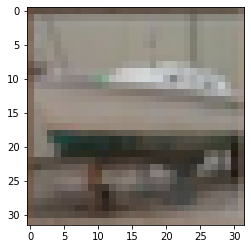

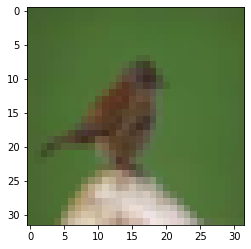

predicted ship
true ship
****************************************************************************************************


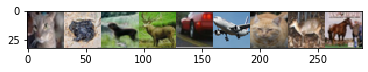

tensor([3.0390e-06, 1.0928e-03, 1.7881e-07, 4.6779e-07, 2.6083e-04, 2.0244e-06,
        4.9399e-05, 1.6418e-05, 9.9857e-01], device='cuda:0',
       dtype=torch.float64)


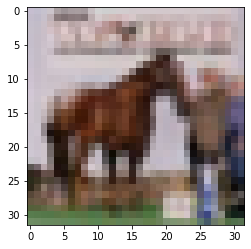

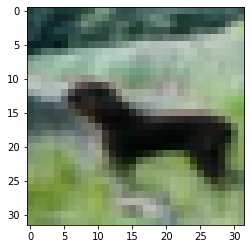

predicted horse
true horse
****************************************************************************************************


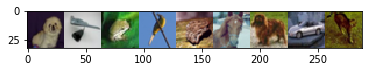

tensor([9.6744e-01, 1.4560e-05, 6.4216e-09, 5.2216e-08, 3.9755e-03, 1.2699e-02,
        1.1680e-02, 4.1895e-03, 6.8565e-07], device='cuda:0',
       dtype=torch.float64)


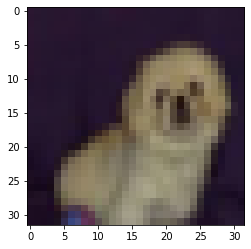

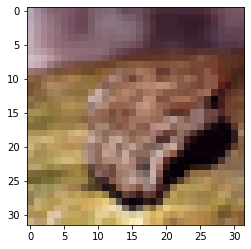

predicted horse
true horse
****************************************************************************************************


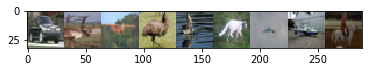

tensor([3.8451e-05, 2.0158e-01, 2.5008e-01, 2.5233e-06, 9.2813e-02, 1.4771e-01,
        1.4221e-02, 8.8794e-06, 2.9355e-01], device='cuda:0',
       dtype=torch.float64)


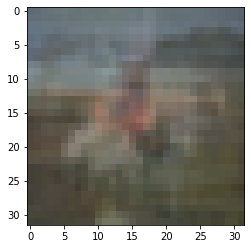

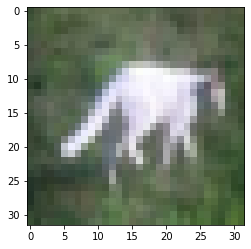

predicted truck
true horse
****************************************************************************************************


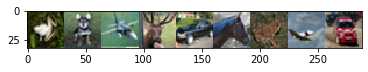

tensor([6.8090e-10, 8.7215e-03, 8.2012e-02, 3.9405e-03, 3.2990e-01, 2.9629e-01,
        8.5309e-03, 7.1547e-04, 2.6989e-01], device='cuda:0',
       dtype=torch.float64)


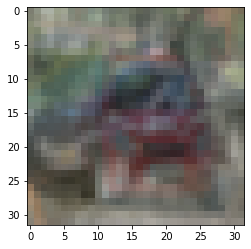

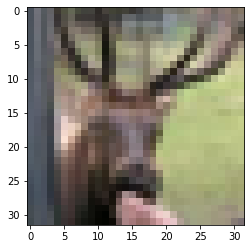

predicted truck
true horse
****************************************************************************************************


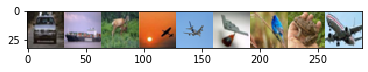

tensor([2.7724e-06, 9.9997e-01, 2.8694e-07, 2.9333e-05, 4.0552e-13, 3.0789e-08,
        6.8622e-09, 4.2134e-07, 8.9466e-08], device='cuda:0',
       dtype=torch.float64)


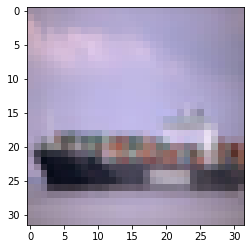

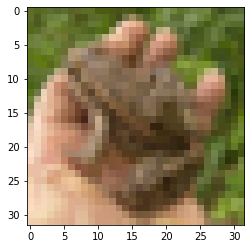

predicted ship
true ship
****************************************************************************************************


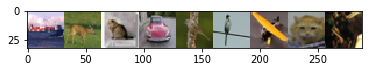

tensor([9.6894e-01, 1.4945e-04, 4.9630e-03, 2.5649e-02, 6.0658e-06, 4.2408e-06,
        1.0749e-05, 2.0778e-04, 7.3553e-05], device='cuda:0',
       dtype=torch.float64)


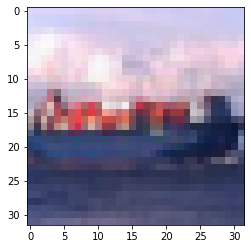

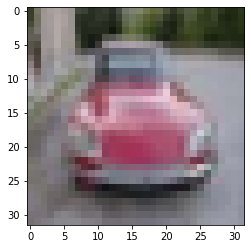

predicted ship
true ship
****************************************************************************************************


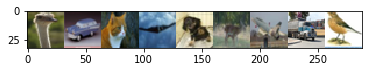

tensor([3.5505e-03, 3.2253e-02, 6.8159e-03, 1.5089e-03, 7.0043e-06, 1.9763e-01,
        1.8370e-01, 5.7451e-01, 3.1124e-05], device='cuda:0',
       dtype=torch.float64)


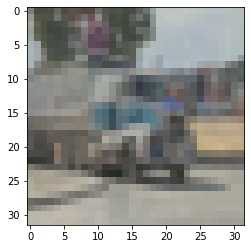

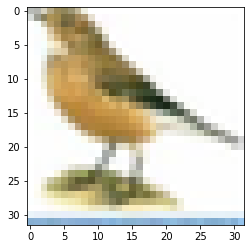

predicted truck
true truck
****************************************************************************************************


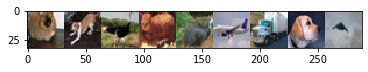

tensor([1.4796e-02, 1.4306e-02, 7.1878e-04, 9.0703e-01, 4.2096e-05, 1.3365e-06,
        6.1583e-02, 1.5184e-03, 6.8139e-07], device='cuda:0',
       dtype=torch.float64)


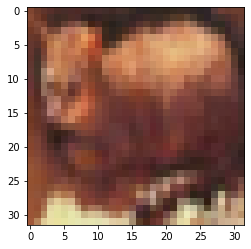

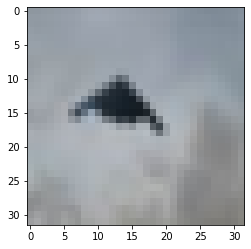

predicted truck
true truck
****************************************************************************************************


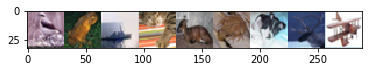

tensor([1.8778e-16, 5.8057e-12, 1.0000e+00, 3.8813e-12, 1.8889e-12, 5.4497e-14,
        1.4022e-15, 6.4275e-14, 5.2351e-12], device='cuda:0',
       dtype=torch.float64)


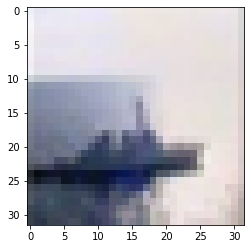

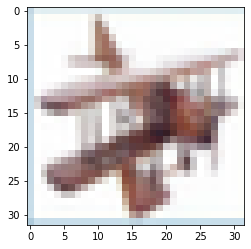

predicted ship
true ship
****************************************************************************************************


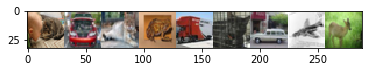

tensor([6.3215e-01, 2.1655e-04, 1.6550e-02, 2.3338e-02, 3.2217e-01, 5.0831e-03,
        8.8199e-05, 2.7131e-05, 3.7819e-04], device='cuda:0',
       dtype=torch.float64)


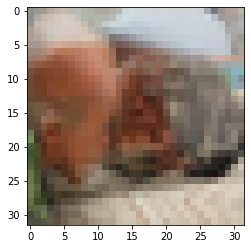

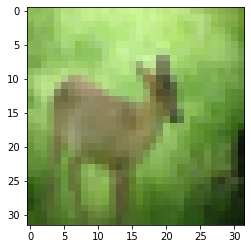

predicted truck
true truck
****************************************************************************************************


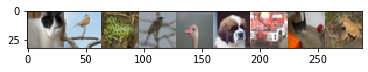

tensor([1.4678e-05, 3.1968e-03, 3.2143e-01, 1.2334e-01, 1.4969e-01, 5.7970e-05,
        5.6874e-02, 1.0414e-01, 2.4127e-01], device='cuda:0',
       dtype=torch.float64)


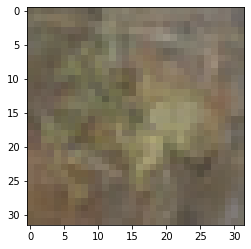

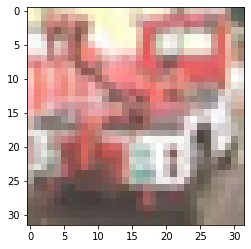

predicted truck
true truck
****************************************************************************************************


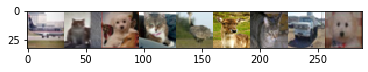

tensor([5.5739e-03, 1.8688e-05, 2.3068e-03, 1.3237e-04, 8.6940e-04, 6.4396e-03,
        1.0227e-02, 9.7408e-01, 3.5605e-04], device='cuda:0',
       dtype=torch.float64)


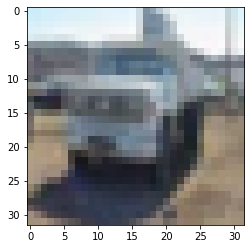

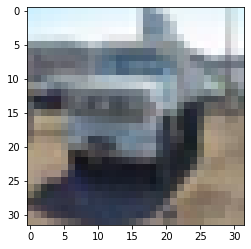

predicted truck
true truck
****************************************************************************************************


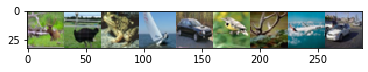

tensor([4.9334e-05, 5.9860e-04, 5.9910e-05, 9.8745e-01, 2.5814e-05, 1.7220e-05,
        2.6825e-04, 8.2277e-07, 1.1533e-02], device='cuda:0',
       dtype=torch.float64)


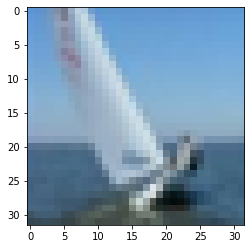

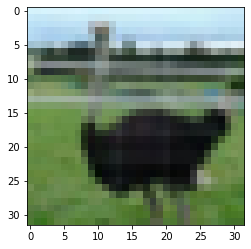

predicted ship
true ship
****************************************************************************************************


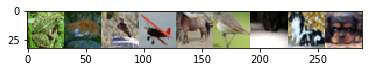

tensor([4.4199e-05, 2.7108e-03, 2.3094e-03, 7.7174e-04, 9.9097e-01, 1.5815e-04,
        8.4083e-05, 5.0301e-04, 2.4436e-03], device='cuda:0',
       dtype=torch.float64)


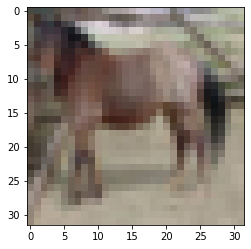

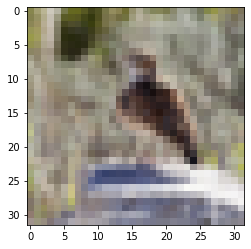

predicted horse
true horse
****************************************************************************************************


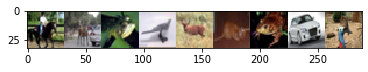

tensor([9.0391e-02, 2.8258e-01, 3.8024e-04, 3.7290e-04, 1.9936e-01, 3.9447e-01,
        8.3228e-04, 1.3470e-03, 3.0260e-02], device='cuda:0',
       dtype=torch.float64)


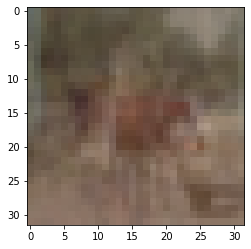

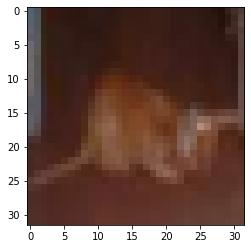

predicted horse
true horse
****************************************************************************************************


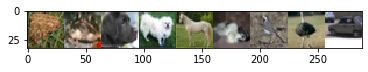

tensor([5.7270e-03, 1.6084e-03, 5.2620e-02, 2.1623e-04, 9.1238e-01, 1.1079e-03,
        1.9831e-02, 2.9383e-03, 3.5754e-03], device='cuda:0',
       dtype=torch.float64)


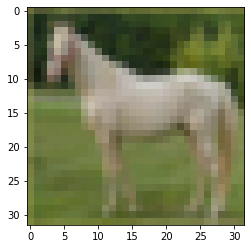

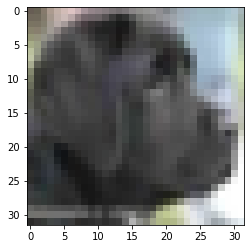

predicted horse
true horse
****************************************************************************************************


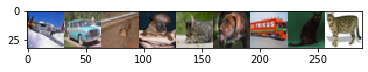

tensor([1.9006e-11, 9.8192e-06, 3.9049e-06, 9.0779e-06, 3.1401e-05, 3.6694e-05,
        9.9991e-01, 6.0865e-07, 1.3205e-07], device='cuda:0',
       dtype=torch.float64)


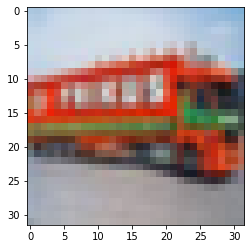

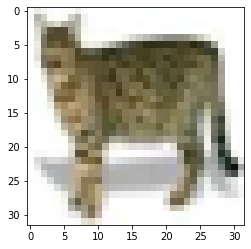

predicted truck
true truck
****************************************************************************************************


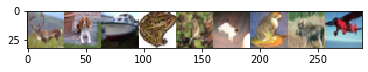

tensor([2.0738e-10, 6.1752e-12, 1.0000e+00, 7.9182e-11, 2.0655e-10, 1.9645e-11,
        6.2044e-11, 5.3632e-09, 1.6191e-09], device='cuda:0',
       dtype=torch.float64)


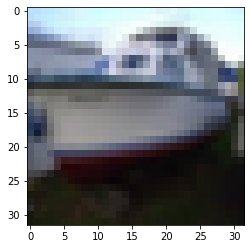

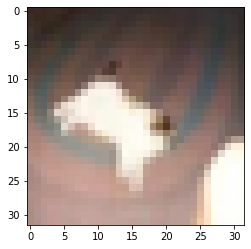

predicted ship
true ship
Accuracy of the network on the 10000 test images: 79 %
total correct 7965
total test set images 10000


In [159]:
correct = 0
total = 0
flag =1
with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs,labels = inputs.to("cuda"),labels.to("cuda") 
    avg_images , alphas = where_net(inputs)
    outputs = what_net(avg_images)
    _, predicted = torch.max(outputs.data, 1)


    if flag==1 :
      for j in range (50):
        print("*"*100)
        img1 = torch.cat((inputs[j][0], inputs[j][1], inputs[j][2], inputs[j][3], inputs[j][4], inputs[j][5], inputs[j][6], inputs[j][7], inputs[j][8]) , 2)
        display(img1.cpu())

        print(alphas[j])

        img2 = avg_images[j]
        display(img2.cpu())

        img3 = inputs[j][fore_idx_test[j]]
        display(img3.cpu())

        print("predicted", classes[predicted[j]+7])
        print("true", classes[labels[j]+7])

      flag =0


    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
print("total correct", correct)
print("total test set images", total)

In [0]:
a = torch.tensor([0.0071, 0.0466, 0.0025, 0.0282, 0.0140, 0.0067, 0.0145, 0.8750, 0.0055])

In [161]:
print(torch.argmax(a) == 7)
print(batch)

tensor(True)
250


In [162]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

train_loader1 = DataLoader( msd,batch_size= batch ,shuffle=False)
with torch.no_grad():
  for data in train_loader1:
    inputs, labels , fore_idx = data
    inputs,labels = inputs.to("cuda"),labels.to("cuda") 
    avg_images , alphas = where_net(inputs)
    outputs = what_net(avg_images)
    _, predicted = torch.max(outputs.data, 1)
    
    for j in range (batch):
      focus = torch.argmax(alphas[j])
      
      if(alphas[j][focus] >= 0.5):
        argmax_more_than_half +=1
      else:
        argmax_less_than_half +=1
        
      if(focus == fore_idx[j] and predicted[j] == labels[j]):
        focus_true_pred_true += 1
        
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true +=1
        
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false +=1
        
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false +=1
      
#       print("*"*100)
#       img1 = torch.cat((inputs[j][0], inputs[j][1], inputs[j][2], inputs[j][3], inputs[j][4], inputs[j][5], inputs[j][6], inputs[j][7], inputs[j][8]) , 2)
#       display(img1)

#       print(alphas[j])

#       img2 = avg_images[j]
#       display(img2)

#       img3 = inputs[j][fore_idx[j]]
#       display(img3)

#       print("predicted", classes[predicted[j]+7])
#       print("true", classes[labels[j]+7])

     
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true",focus_true_pred_true)
print("focus_false_pred_true",focus_false_pred_true )
print("focus_true_pred_false",focus_true_pred_false )
print("focus_false_pred_false",focus_false_pred_false)

print("argmax_more_than_half",argmax_more_than_half)
print("argmax_less_than_half",argmax_less_than_half)

Accuracy of the network on the 30000 train images: 97 %
total correct 29214
total train set images 30000
focus_true_pred_true 22563
focus_false_pred_true 6651
focus_true_pred_false 138
focus_false_pred_false 648
argmax_more_than_half 27868
argmax_less_than_half 2132


In [163]:
bg_idx = np.random.randint(0,35000,8)
fg_idx = np.random.randint(0,15000)
fg = np.random.randint(0,9)
fore_idx_test.append(fg)
image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
test_images.append(image_list)
test_label.append(label)
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs,labels = inputs.to("cuda"),labels.to("cuda") 
    avg_images , alphas = where_net(inputs)
    outputs = what_net(avg_images)

    _, predicted = torch.max(outputs.data, 1)
    
    for j in range (batch):
      focus = torch.argmax(alphas[j])
      
      if(alphas[j][focus] >= 0.5):
        argmax_more_than_half +=1
      else:
        argmax_less_than_half +=1
        
      if(focus == fore_idx[j] and predicted[j] == labels[j]):
        focus_true_pred_true += 1
        
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true +=1
        
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false +=1
        
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false +=1
      
#       print("*"*100)
#       img1 = torch.cat((inputs[j][0], inputs[j][1], inputs[j][2], inputs[j][3], inputs[j][4], inputs[j][5], inputs[j][6], inputs[j][7], inputs[j][8]) , 2)
#       display(img1)

#       print(alphas[j])

#       img2 = avg_images[j]
#       display(img2)

#       img3 = inputs[j][fore_idx[j]]
#       display(img3)

#       print("predicted", classes[predicted[j]+7])
#       print("true", classes[labels[j]+7])

     
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true",focus_true_pred_true)
print("focus_false_pred_true",focus_false_pred_true )
print("focus_true_pred_false",focus_true_pred_false )
print("focus_false_pred_false",focus_false_pred_false)

print("argmax_more_than_half",argmax_more_than_half)
print("argmax_less_than_half",argmax_less_than_half)

Accuracy of the network on the 30000 train images: 79 %
total correct 7965
total train set images 10000
focus_true_pred_true 6666
focus_false_pred_true 1299
focus_true_pred_false 342
focus_false_pred_false 1693
argmax_more_than_half 8966
argmax_less_than_half 1034


In [0]:
# epoch = 100
# for i in range(epoch):
#   if (i %40) <20:
#     print("What",i)
#   elif (i%40)>20:
#     print("Where",i)